# Importazione librerie

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ccxt
import time
from math import isclose
import Metriche_di_performance as mdp
import numpy as np
from sklearn.model_selection import ParameterGrid
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from copy import deepcopy
from typing import Callable

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
import random
import os

In [2]:
pd.options.display.max_columns = None

In [3]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Function

In [4]:
def calcola_rendimento_portafoglio_ideale_multicrypto(lista_colonne_prezzi, capitale_iniziale, lista_token_iniziali, min_acquisto=0, min_vendita=0, perc_commissione_acquisto=0, perc_commissione_vendita=0):
    # lista_colonne_prezzi è una lista di pd.Series dei prezzi di ciascuna delle N crypto
    # Supponiamo: N = len(lista_colonne_prezzi)
    # Tutte le serie hanno la stessa lunghezza
    # i-esimo giorno: lista_colonne_prezzi[j][i] è il prezzo della j-esima crypto
    N = len(lista_colonne_prezzi)
    n = len(lista_colonne_prezzi[0])
    
    # Converto i prezzi in una matrice per comodità
    prezzi = []
    for i in range(n):
        prezzi_giorno = [lista_colonne_prezzi[j].iloc[i] for j in range(N)]
        prezzi.append(prezzi_giorno)

    # dp[i][0]: max capitale in USD se a fine giorno i non detengo crypto
    # dp[i][j]: max numero di token della j-esima crypto se a fine giorno i detengo crypto j (j = 1,...,N)
    # Nota: l'indice 0 in dp si riferisce allo stato "nessuna crypto"
    dp = [[float('-inf')] * (N+1) for _ in range(n)]

    # Stato iniziale
    dp[0][0] = capitale_iniziale
    for j in range(1, N+1):
        dp[0][j] = lista_token_iniziali[j-1]  # numero di token iniziali della j-esima crypto

    # Valore iniziale del portafoglio
    valore_iniziale = capitale_iniziale
    for j in range(N):
        valore_iniziale += lista_token_iniziali[j] * prezzi[0][j]

    for i in range(1, n):
        for stato_precedente in range(N+1):
            if dp[i-1][stato_precedente] == float('-inf'):
                continue
            
            # Caso 1: mantengo lo stesso stato (nessuna operazione)
            if stato_precedente == 0:
                # Nessuna crypto ieri, nessuna oggi
                dp[i][0] = max(dp[i][0], dp[i-1][0])
            else:
                # Avevo la crypto stato_precedente
                dp[i][stato_precedente] = max(dp[i][stato_precedente], dp[i-1][stato_precedente])

            # Caso 2: se ero senza crypto ieri, posso comprare crypto k oggi
            if stato_precedente == 0:
                # ho capitale in USD = dp[i-1][0]
                capitale = dp[i-1][0]
                for k in range(1, N+1):
                    if capitale >= min_acquisto:
                        # Compro crypto k
                        bitcoin_acquistati = (capitale * (1 - perc_commissione_acquisto)) / prezzi[i][k-1]
                        if bitcoin_acquistati * prezzi[i][k-1] >= min_acquisto:
                            dp[i][k] = max(dp[i][k], bitcoin_acquistati)

            # Caso 3: se avevo la crypto j ieri, posso vendere oggi e andare in USD
            if stato_precedente > 0:
                # stato_precedente è una crypto j-esima
                j_crypto = stato_precedente
                quantita = dp[i-1][j_crypto]  # numero di token
                valore_vendita = quantita * prezzi[i][j_crypto-1]
                if valore_vendita >= min_vendita:
                    capitale_dopo_vendita = valore_vendita * (1 - perc_commissione_vendita)
                    dp[i][0] = max(dp[i][0], capitale_dopo_vendita)

                # Caso 4: se avevo la crypto j, posso vendere e comprare un'altra crypto k
                for k in range(1, N+1):
                    if k != j_crypto:
                        # Vendo j
                        if valore_vendita >= min_vendita:
                            capitale_intermedio = valore_vendita * (1 - perc_commissione_vendita)
                            # Compro k
                            if capitale_intermedio >= min_acquisto:
                                bitcoin_acquistati = (capitale_intermedio * (1 - perc_commissione_acquisto)) / prezzi[i][k-1]
                                if bitcoin_acquistati * prezzi[i][k-1] >= min_acquisto:
                                    dp[i][k] = max(dp[i][k], bitcoin_acquistati)

    # Calcolo del valore finale
    valore_finale = dp[n-1][0]
    for j in range(1, N+1):
        if dp[n-1][j] != float('-inf'):
            # Vendo l'ultima crypto
            valore_uscita = dp[n-1][j] * prezzi[-1][j-1] * (1 - perc_commissione_vendita)
            valore_finale = max(valore_finale, valore_uscita)

    rendimento = valore_finale / valore_iniziale
    return [rendimento, valore_finale]

In [5]:
def compute_last_local_max(series: pd.Series) -> pd.Series:
    """
    Per ogni indice i, restituisce il valore (non l'indice) dell’ultimo massimo locale
    avvenuto in un giorno j < i, con definizione:
    
    - j=0 è un massimo locale se series[0] > series[1].
    - per 0 < j < len(series)-1, j è massimo locale se:
        series[j] >= series[j-1] e series[j] >= series[j+1]
    - l’ultimo giorno (j = len-1) non viene considerato un massimo locale.
    
    Ritorna una Series 'last_local_max' tale che:
       last_local_max[i] = series[j]  (dove j è l’ultimo massimo locale con j < i)
       se non esiste j < i che sia un massimo locale, last_local_max[i] = NaN
    """
    arr = series.values
    n = len(arr)
    
    # Array booleana per marcare i massimi locali
    is_local_max = np.zeros(n, dtype=bool)
    
    if n == 1:
        # Con un solo punto non si può definire un massimo locale nel senso classico.
        # Ritorniamo una serie di NaN.
        return pd.Series([np.nan], index=series.index)
    
    # Controllo per il primo indice
    if arr[0] > arr[1]:
        is_local_max[0] = True
    
    # Controllo per l'intervallo [1..n-2]
    # (l'ultimo indice n-1 non si considera per la definizione di massimo locale)
    for i in range(1, n-1):
        if arr[i] >= arr[i-1] and arr[i] >= arr[i+1]:
            is_local_max[i] = True
    
    # Costruiamo la serie che, per ogni i, dice "valore dell'ultimo max locale avvenuto prima di i"
    last_local_max = np.full(n, np.nan)
    
    last_max_value = np.nan
    
    for i in range(n):
        # Se i è un massimo locale, aggiorniamo last_max_value
        if is_local_max[i]:
            last_max_value = arr[i]
        
        last_local_max[i] = last_max_value
    
    return pd.Series(last_local_max, index=series.index)

In [6]:
# def liquidity_out_function(current_liquidity: float, coef_liquidity_out:float, variation_percent_ma: float) -> float:
#     """
#     Funzione che calcola la nuova percentuale di liquidità desiderata quando 
#     TUTTE le crypto sono in discesa (M.A. < ultimo max locale).
#     Aumentiamo la liquidità in base al modulo della variazione percentuale 
#     della media mobile della variazione percentuale del prezzo medio.
#     """
#     new_liquidity = current_liquidity + coef_liquidity_out * abs(variation_percent_ma)
#     # Limitiamo tra 0 e 1
#     return min(max(new_liquidity, 0), 1)

In [7]:
# def liquidity_in_function(current_liquidity: float, coef_liquidity_in: float, variation_percent_ma: float) -> float:
#     """
#     Funzione che calcola la nuova percentuale di liquidità desiderata quando
#     ALMENO UNA crypto è in salita (M.A. >= ultimo max locale).
#     Riduciamo la liquidità in base alla variazione percentuale 
#     della media mobile della variazione percentuale del prezzo medio.
#     """
#     # if variation_percent_ma in [0, None] and coef_liquidity_in == np.inf:
#     #     return 0
    
#     new_liquidity = current_liquidity - coef_liquidity_in * variation_percent_ma
#     # Limitiamo tra 0 e 1
#     return min(max(new_liquidity, 0), 1)

In [8]:
def download_and_plot(cryptos, market, timeframe_download, start_date, end_date, plot):
    
    # exchange = ccxt.binance()  # Usa Binance come exchange
    exchange_class = getattr(ccxt, market)  # Ottieni la classe dell'exchange
    exchange = exchange_class()  # Crea un'istanza dell'exchange
    exchange.load_markets()  # Carica i mercati disponibili
    cryptos_pairs = [f"{crypto}/USDT" for crypto in cryptos]  # Adatta i simboli per Binance

    # Converti date in timestamp
    start_timestamp = int(pd.Timestamp(start_date).timestamp() * 1000)
    end_timestamp = int(pd.Timestamp(end_date).timestamp() * 1000)

    data_frames = {}

    for pair in cryptos_pairs:
        if pair not in exchange.markets:
            raise ValueError(f"Il mercato {pair} non è disponibile su Binance.")

        print(f"Scarico i dati per {pair} dal {start_date} al {end_date}...")
        
        ohlcv = []
        since = start_timestamp

        # Scarica i dati in blocchi fino a raggiungere la data di fine
        while since < end_timestamp:
            batch = exchange.fetch_ohlcv(pair, timeframe_download, since)
            if not batch:
                break
            ohlcv.extend(batch)
            since = batch[-1][0] + 1  # Avanza al prossimo blocco
            time.sleep(exchange.rateLimit / 1000)  # Rispetta il rate limit dell'API

        # Crea un DataFrame dai dati
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)

        # Filtra i dati oltre la data di fine
        df = df[df.index <= pd.Timestamp(end_date)]
        data_frames[pair] = df

        if plot:
            # Plot dei dati
            plt.figure(figsize=(14, 8))

            # Grafico della prima crypto
            plt.subplot(3, 1, 1)
            plt.plot(data_frames[pair].index, data_frames[pair]['close'], label=f"{pair} Price")
            plt.title(f"{pair} Price")
            plt.ylabel('Price (USDT)')
            plt.grid()
            # plt.legend()

            plt.tight_layout()
            plt.show()

    return {k.replace('/USDT', ''): v for k, v in data_frames.items()}

# Strategia

In [9]:
def portfolio_value(prices_row: pd.Series, quantities_dict: dict, liquidity_amount: float) -> float:
    """
    Calcola il valore totale del portafoglio (sommando le crypto e la liquidità).
    """
    total = liquidity_amount
    for c in quantities_dict.keys():
        total += quantities_dict[c] * prices_row[c]
    return total

In [10]:
def trova_massimi_minimi_locali(series: pd.Series) -> (pd.Series, pd.Series): # type: ignore
    """
    Dati i valori di 'series', individua i massimi e minimi locali secondo la regola:
    
    - Per i = 0 (primo elemento), se series[0] > series[1], allora series[0] è un massimo locale.
      Se series[0] <= series[1], allora series[0] è un minimo locale.
    - Per 0 < i < len(series) - 1:
        * massimi se series[i-1] < series[i] > series[i+1]
        * minimi se series[i-1] > series[i] < series[i+1]
    - L'ultimo elemento (i = len(series)-1) non viene considerato per definizione.
    
    Ritorna due pd.Series (massimi, minimi) dove i valori sono NaN se non è un estremo locale,
    oppure il valore della series se è un massimo/minimo locale.
    """
    n = len(series)
    
    massimi = pd.Series(data=np.nan, index=series.index, dtype=float)
    minimi = pd.Series(data=np.nan, index=series.index, dtype=float)
    
    if n == 0 or n == 1:
        # Con un solo punto o nessuno, non possiamo definire un massimo o minimo locale
        return massimi, minimi
    
    # Gestione del primo elemento (i=0)
    if n >= 2:
        if series.iloc[0] > series.iloc[1]:
            massimi.iloc[0] = series.iloc[0]
        else:
            minimi.iloc[0] = series.iloc[0]
    
    # Gestione degli elementi intermedi (1 .. n-2)
    for i in range(1, n-1):
        if (series.iloc[i-1] < series.iloc[i] > series.iloc[i+1]):
            massimi.iloc[i] = series.iloc[i]
        elif (series.iloc[i-1] > series.iloc[i] < series.iloc[i+1]):
            minimi.iloc[i] = series.iloc[i]
    
    # L'ultimo elemento (i = n-1) non lo consideriamo come massimo o minimo locale
    
    return massimi, minimi

In [11]:
def trova_ultimo_estremo_locale(series: pd.Series,
                               massimi: pd.Series,
                               minimi: pd.Series) -> (pd.Series, pd.Series): # type: ignore
    """
    Dato un vettore 'series' e i suoi 'massimi' e 'minimi' locali (come restituiti da
    trova_massimi_minimi_locali), costruisce due Series:
      - last_ext_type: 'max' o 'min' (oppure None/NaN se non c'è stato ancora un estremo)
      - last_ext_value: valore dell'ultimo estremo locale incontrato finora (NaN se nessuno)
    
    Esempio: per i=0, last_ext_type[0] è 'max' se massimi[0] non è NaN, 
             'min' se minimi[0] non è NaN, altrimenti None.
    """
    n = len(series)
    last_ext_type_arr = [None]*n
    last_ext_value_arr = [None]*n
    
    current_type = None
    current_value = None
    
    for i in range(n):
        if not pd.isna(massimi.iloc[i]):
            current_type = 'max'
            current_value = massimi.iloc[i]
        elif not pd.isna(minimi.iloc[i]):
            current_type = 'min'
            current_value = minimi.iloc[i]
        
        last_ext_type_arr[i] = current_type
        last_ext_value_arr[i] = current_value
    
    last_ext_type = pd.Series(last_ext_type_arr, index=series.index, dtype=object)
    last_ext_value = pd.Series(last_ext_value_arr, index=series.index, dtype=float)
    return last_ext_type, last_ext_value

In [12]:
def func_liquidity_out(current_liquidity: float,
                           coef_liquidity_out: float,
                           variation_percent_ma: float) -> float:
    """
    Aumenta la liquidità in base al coefficiente e alla variazione percentuale (assoluta).
    Limitata tra 0 e 1.
    """
    if coef_liquidity_out == np.inf and variation_percent_ma == 0:
        return 1

    new_liquidity_pct = current_liquidity + coef_liquidity_out * abs(variation_percent_ma)
    return min(max(new_liquidity_pct, 0), 1)

In [13]:
def func_liquidity_in(current_liquidity: float,
                          coef_liquidity_in: float,
                          variation_percent_ma: float) -> float:
    """
    Riduce la liquidità in base al coefficiente e alla variazione percentuale (positiva).
    Limitata tra 0 e 1.
    """
    if coef_liquidity_in == np.inf and variation_percent_ma == 0:
        return 0

    new_liquidity_pct = current_liquidity - coef_liquidity_in * variation_percent_ma
    return min(max(new_liquidity_pct, 0), 1)

In [14]:
def param_str(x):
    """Restituisce il nome se x è una funzione, altrimenti la stringa normale."""
    if callable(x):
        return x.__name__  # così vedrò "ma_prices", "mstd_returns_prices", ecc.
    return str(x)

def is_params_present(params, file):
    """
    Verifica se la combinazione di parametri specificata è già presente nel file 'Risultati.csv'.

    Args:
        params (dict): Dizionario con nomi e valori dei parametri da cercare.

    Returns:
        bool: True se la combinazione è presente, False altrimenti.
    """

    masks = []
    for key in params.keys():
        col = file[key]
        param_val = params[key]
        
        # Se la colonna è numerica, confronta come numeri
        if pd.api.types.is_numeric_dtype(col):
            # Converti il parametro al tipo della colonna (es. int -> float)
            mask = (col.astype(float) == float(param_val))
        elif key != 'func_monitor':
            # Confronto come stringhe per colonne non numeriche
            mask = (col.astype(str) == str(param_val))
        else:
            mask = (col.astype(str) == str(param_val.__name__))
        
        masks.append(mask)
    
    # Combina tutte le maschere con AND logico
    final_mask = pd.concat(masks, axis=1).all(axis=1)
    return final_mask.any()

def grid_search_rebalancing_2(dati, grid_params, initial_allocations, initial_liquidity, skip_conditions, sort_quantity, save_each, start, file):

    risultati = []

    # Iterazione nella grid search
    for idx, params in enumerate(grid_params):
        if idx+1 >= start:
            global mini_grid_search_activated
            mini_grid_search_activated = False # Ho dovuto creare 2 function distinte grid_search_rebalancing e mini_grid_search_rebalancing perchè in quella mini devo lasciare mini_grid_search_activated com'è, mentre nella grid search normale è importante reinizializzare mini_grid_search_activated a False prima di ogni combinazione che testo
            display_dict = {k: param_str(v) for k,v in params.items()}
            print(f"\nInizio iterazione {idx+1}/{len(grid_params)}")
            print(f"Parametri: {display_dict}")

            combinazione_già_presente = is_params_present(params, file)

            if not skip_conditions[idx] and not combinazione_già_presente:
                # Esegui la strategia
                risultati_df = simulate_trading_strategy_2( # type: ignore
                    dati,
                    initial_liquidity,
                    initial_allocations,
                    params['timeframe'],
                    params['timeframe_grid_search'],
                    params['mobile_window'],
                    params['weighting_factor'],
                    params['coef_liquidity_out'],
                    params['coef_liquidity_in'],
                    params['dynamical_variables'],
                    params['window_grid_search'],
                    params['func_monitor']
                )

                # Calcola il fattore di rendimento totale
                fattore_rendimento_totale = risultati_df['portfolio_value'].iloc[-1] / risultati_df['portfolio_value'].iloc[0]
                volatility = mdp.volatility(risultati_df['portfolio_value'])
                max_drawdown = mdp.max_drawdown(risultati_df['portfolio_value'])
                sharpe_ratio = mdp.sharpe_ratio(risultati_df['portfolio_value'])
                sortino_ratio = mdp.sortino_ratio(risultati_df['portfolio_value'])
                calmar_ratio = mdp.calmar_ratio(risultati_df['portfolio_value'])

                risultato = {
                    **{name: params[name] for name in grid_params[0].keys()},
                    'fattore_rendimento_totale': fattore_rendimento_totale,
                    'volatility': volatility,
                    'max_drawdown': max_drawdown,
                    'sharpe_ratio': sharpe_ratio,
                    'sortino_ratio': sortino_ratio,
                    'calmar_ratio': calmar_ratio
                }

                risultato_df = pd.DataFrame([risultato])
                risultati.append(risultato)

                print(f"Iterazione {idx + 1} completata: Fattore Rendimento Totale = {fattore_rendimento_totale}\n")

                if save_each:
                    global total_results, csv_name
                    csv_name = 'Risultati 2 Rotazione multi-asset con medie mobili'

                    # Converti eventuali colonne di tipo dict in stringa
                    for col in risultato_df.columns:
                        # Converti ogni cella che è un dict in una stringa
                        risultato_df[col] = risultato_df[col].apply(lambda x: str(x) if isinstance(x, dict) else x)
                        # Converti ogni cella callable nel suo __name__
                        risultato_df[col] = risultato_df[col].apply(lambda x: x.__name__ if callable(x) else x)

                    # Carica i vecchi risultati dal file CSV
                    try:
                        old_results = pd.read_csv(f'{csv_name}.csv')
                    except FileNotFoundError:
                        old_results = pd.DataFrame()  # Crea un DataFrame vuoto se il file non esiste

                    # Concatena i vecchi e nuovi risultati, rimuovendo duplicati e reindicizzando
                    total_results = pd.concat([old_results, risultato_df]).drop_duplicates().reset_index(drop=True)
                    total_results = total_results.sort_values(by='fattore_rendimento_totale', ascending=False)

                    # Salva i risultati aggiornati nel file CSV senza l'indice
                    total_results.to_csv(f'{csv_name}.csv', index=False)
                    print(f'Ho aggiunto la combinazione appena calcolata in {csv_name}.csv')
            elif combinazione_già_presente:
                print('Salto questa combinazione perchè è già presente nel csv...\n')
            elif skip_conditions[idx]:
                print('Salto questa combinazione perchè sarebbe uguale a un\'altra già vista...\n')

    # Ordina i risultati in ordine decrescente per fattore di rendimento totale
    risultati_df = pd.DataFrame(risultati)
    risultati_df = risultati_df.sort_values(by=sort_quantity, ascending=False).reset_index(drop=True)

    # print("Grid search completata. Migliori risultati:")

    return risultati_df


def mini_grid_search_rebalancing_2(dati, grid_params, initial_allocations, initial_liquidity, skip_conditions, sort_quantity):

    risultati = []

    # Iterazione nella grid search
    for idx, params in enumerate(grid_params):
        display_dict = {k: param_str(v) for k,v in params.items()}
        print(f"\nInizio iterazione {idx+1}/{len(grid_params)}")
        print(f"Parametri: {display_dict}")

        if not skip_conditions[idx]:
            # Esegui la strategia
            risultati_df = simulate_trading_strategy_2( # type: ignore
                dati,
                initial_liquidity,
                initial_allocations,
                params['timeframe'],
                params['timeframe_grid_search'],
                params['mobile_window'],
                params['weighting_factor'],
                params['coef_liquidity_out'],
                params['coef_liquidity_in'],
                params['dynamical_variables'],
                params['window_grid_search'],
                params['func_monitor']
            )

            # Calcola il fattore di rendimento totale
            fattore_rendimento_totale = risultati_df['portfolio_value'].iloc[-1] / risultati_df['portfolio_value'].iloc[0]
            volatility = mdp.volatility(risultati_df['portfolio_value'])
            max_drawdown = mdp.max_drawdown(risultati_df['portfolio_value'])
            sharpe_ratio = mdp.sharpe_ratio(risultati_df['portfolio_value'])
            sortino_ratio = mdp.sortino_ratio(risultati_df['portfolio_value'])
            calmar_ratio = mdp.calmar_ratio(risultati_df['portfolio_value'])

            risultati.append({
                **{name: params[name] for name in grid_params[0].keys()},
                'fattore_rendimento_totale': fattore_rendimento_totale,
                'volatility': volatility,
                'max_drawdown': max_drawdown,
                'sharpe_ratio': sharpe_ratio,
                'sortino_ratio': sortino_ratio,
                'calmar_ratio': calmar_ratio
            })

            print(f"Iterazione {idx + 1} completata: Fattore Rendimento Totale = {fattore_rendimento_totale}\n")

        else:
            print('Salto questa combinazione perchè sarebbe uguale a un\'altra già vista...\n')

    # Ordina i risultati in ordine decrescente per fattore di rendimento totale
    risultati_df = pd.DataFrame(risultati)
    risultati_df = risultati_df.sort_values(by=sort_quantity, ascending=False).reset_index(drop=True)

    # print("Grid search completata. Migliori risultati:")

    return risultati_df

In [15]:
# Funzione che calcola la media mobile delle variazioni percentuali dei prezzi
def ma_returns_prices(prices_df: pd.DataFrame, window: int) -> pd.DataFrame:
    """
    Calcola la media mobile delle variazioni percentuali dei prezzi.

    Restituisce un DataFrame con:
      - colonna 'avg_metric' = MA delle variazioni percentuali medie
      - per ogni crypto c: 'metric_{c}' = MA delle variazioni percentuali di c
    """
    df_copy = prices_df.copy()
    df_copy.sort_index(inplace=True)
    
    daily_returns = df_copy.pct_change()

    # Calcolo media mobile delle variazioni percentuali per ogni crypto
    for col in prices_df.columns:
        df_copy[f"metric_{col}"] = daily_returns[col].rolling(window=window).mean()
    
    # Media della metrica tra tutte le crypto
    metric_cols = [f"metric_{c}" for c in prices_df.columns]
    df_copy['avg_metric'] = df_copy[metric_cols].mean(axis=1)
    
    return df_copy

# Funzione che calcola la deviazione standard mobile delle variazioni percentuali dei prezzi
def mstd_returns_prices(prices_df: pd.DataFrame, window: int) -> pd.DataFrame:
    """
    Calcola la deviazione standard mobile delle variazioni percentuali dei prezzi.

    Restituisce un DataFrame con:
      - colonna 'avg_metric' = std mobile delle variazioni percentuali medie
      - per ogni crypto c: 'metric_{c}' = std mobile delle variazioni percentuali di c
    """
    df_copy = prices_df.copy()
    df_copy.sort_index(inplace=True)
    
    daily_returns = df_copy.pct_change()

    # Calcolo deviazione standard mobile delle variazioni percentuali per ogni crypto
    for col in prices_df.columns:
        df_copy[f"metric_{col}"] = daily_returns[col].rolling(window=window).std()
    
    # Media della metrica tra tutte le crypto
    metric_cols = [f"metric_{c}" for c in prices_df.columns]
    df_copy['avg_metric'] = df_copy[metric_cols].mean(axis=1)
    
    return df_copy

# Funzione che calcola la media mobile dei prezzi
def ma_prices(prices_df: pd.DataFrame, window: int) -> pd.DataFrame:
    """
    Calcola la media mobile dei prezzi.

    Restituisce un DataFrame con:
      - colonna 'avg_metric' = MA media tra tutte le crypto
      - per ogni crypto c: 'metric_{c}' = MA del prezzo di c
    """
    df_copy = prices_df.copy()
    df_copy.sort_index(inplace=True)

    # Calcolo media mobile dei prezzi per ogni crypto
    for col in prices_df.columns:
        df_copy[f"metric_{col}"] = df_copy[col].rolling(window=window).mean()
        
    # Media della metrica tra tutte le crypto
    metric_cols = [f"metric_{c}" for c in prices_df.columns]
    df_copy['avg_metric'] = df_copy[metric_cols].mean(axis=1)
    
    return df_copy

# Funzione che calcola la deviazione standard mobile dei prezzi
def mstd_prices(prices_df: pd.DataFrame, window: int) -> pd.DataFrame:
    """
    Calcola la deviazione standard mobile dei prezzi.

    Restituisce un DataFrame con:
      - colonna 'avg_metric' = std mobile media tra tutte le crypto
      - per ogni crypto c: 'metric_{c}' = std mobile del prezzo di c
    """
    df_copy = prices_df.copy()
    df_copy.sort_index(inplace=True)

    # Calcolo deviazione standard mobile dei prezzi per ogni crypto
    for col in prices_df.columns:
        df_copy[f"metric_{col}"] = df_copy[col].rolling(window=window).std()
        
    # Media della metrica tra tutte le crypto
    metric_cols = [f"metric_{c}" for c in prices_df.columns]
    df_copy['avg_metric'] = df_copy[metric_cols].mean(axis=1)
    
    return df_copy

# Funzione che calcola la deviazione standard mobile della deviazione standard mobile dei prezzi
def mstd_mstd_prices(prices_df: pd.DataFrame, window: int) -> pd.DataFrame:
    df_copy = prices_df.copy()
    df_copy.sort_index(inplace=True)

    # Calcolo deviazione standard mobile dei prezzi per ogni crypto
    for col in prices_df.columns:
        df_copy[f"metric_{col}"] = df_copy[col].rolling(window=window).std().rolling(window=window).std()
        
    # Media della metrica tra tutte le crypto
    metric_cols = [f"metric_{c}" for c in prices_df.columns]
    df_copy['avg_metric'] = df_copy[metric_cols].mean(axis=1)
    
    return df_copy

# Funzione che calcola la deviazione standard mobile della deviazione standard mobile delle variazioni percentuali dei prezzi
def mstd_mstd_returns_prices(prices_df: pd.DataFrame, window: int) -> pd.DataFrame:
    df_copy = prices_df.copy()
    df_copy.sort_index(inplace=True)
    
    daily_returns = df_copy.pct_change()

    # Calcolo deviazione standard mobile delle variazioni percentuali per ogni crypto
    for col in prices_df.columns:
        df_copy[f"metric_{col}"] = daily_returns[col].rolling(window=window).std().rolling(window=window).std()
    
    # Media della metrica tra tutte le crypto
    metric_cols = [f"metric_{c}" for c in prices_df.columns]
    df_copy['avg_metric'] = df_copy[metric_cols].mean(axis=1)
    
    return df_copy

# Funzione che calcola la deviazione standard mobile della media mobile delle variazioni percentuali dei prezzi
def mstd_ma_returns_prices(prices_df: pd.DataFrame, window: int) -> pd.DataFrame:
    df_copy = prices_df.copy()
    df_copy.sort_index(inplace=True)
    
    daily_returns = df_copy.pct_change()

    # Calcolo deviazione standard mobile delle variazioni percentuali per ogni crypto
    for col in prices_df.columns:
        df_copy[f"metric_{col}"] = daily_returns[col].rolling(window=window).mean().rolling(window=window).std()
    
    # Media della metrica tra tutte le crypto
    metric_cols = [f"metric_{c}" for c in prices_df.columns]
    df_copy['avg_metric'] = df_copy[metric_cols].mean(axis=1)
    
    return df_copy

# Funzione che calcola la media mobile della deviazione standard mobile delle variazioni percentuali dei prezzi
def ma_mstd_returns_prices(prices_df: pd.DataFrame, window: int) -> pd.DataFrame:
    df_copy = prices_df.copy()
    df_copy.sort_index(inplace=True)
    
    daily_returns = df_copy.pct_change()

    # Calcolo deviazione standard mobile delle variazioni percentuali per ogni crypto
    for col in prices_df.columns:
        df_copy[f"metric_{col}"] = daily_returns[col].rolling(window=window).std().rolling(window=window).mean()
    
    # Media della metrica tra tutte le crypto
    metric_cols = [f"metric_{c}" for c in prices_df.columns]
    df_copy['avg_metric'] = df_copy[metric_cols].mean(axis=1)
    
    return df_copy

# Funzione che calcola la deviazione standard mobile della media mobile dei prezzi
def mstd_ma_prices(prices_df: pd.DataFrame, window: int) -> pd.DataFrame:
    df_copy = prices_df.copy()
    df_copy.sort_index(inplace=True)

    # Calcolo deviazione standard mobile dei prezzi per ogni crypto
    for col in prices_df.columns:
        df_copy[f"metric_{col}"] = df_copy[col].rolling(window=window).mean().rolling(window=window).std()
        
    # Media della metrica tra tutte le crypto
    metric_cols = [f"metric_{c}" for c in prices_df.columns]
    df_copy['avg_metric'] = df_copy[metric_cols].mean(axis=1)
    
    return df_copy

# Funzione che calcola la media mobile della deviazione standard mobile dei prezzi
def ma_mstd_prices(prices_df: pd.DataFrame, window: int) -> pd.DataFrame:
    df_copy = prices_df.copy()
    df_copy.sort_index(inplace=True)

    # Calcolo deviazione standard mobile dei prezzi per ogni crypto
    for col in prices_df.columns:
        df_copy[f"metric_{col}"] = df_copy[col].rolling(window=window).std().rolling(window=window).mean()
        
    # Media della metrica tra tutte le crypto
    metric_cols = [f"metric_{c}" for c in prices_df.columns]
    df_copy['avg_metric'] = df_copy[metric_cols].mean(axis=1)
    
    return df_copy

# Funzione che calcola la media mobile della media mobile delle variazioni percentuali dei prezzi
def ma_ma_returns_prices(prices_df: pd.DataFrame, window: int) -> pd.DataFrame:
    df_copy = prices_df.copy()
    df_copy.sort_index(inplace=True)
    
    daily_returns = df_copy.pct_change()

    # Calcolo media mobile delle variazioni percentuali per ogni crypto
    for col in prices_df.columns:
        df_copy[f"metric_{col}"] = daily_returns[col].rolling(window=window).mean().rolling(window=window).mean()
    
    # Media della metrica tra tutte le crypto
    metric_cols = [f"metric_{c}" for c in prices_df.columns]
    df_copy['avg_metric'] = df_copy[metric_cols].mean(axis=1)
    
    return df_copy

## Strategia principale

### Strategia 1

In [16]:
# mini_grid_search_activated = False

# def simulate_trading_strategy(
#     crypto_prices: pd.DataFrame,
#     initial_liquidity: float,
#     initial_allocations: dict,
#     timeframe: int,
#     timeframe_grid_search: int,
#     mobile_window: int,
#     weighting_factor: float,
#     coef_liquidity_out: float,
#     coef_liquidity_in: float,
#     dynamical_variables: dict,
#     window_grid_search: int,
#     func_monitor: Callable
# ) -> pd.DataFrame:
#     """
#     Simula una strategia di trading su un insieme di crypto. Logica:
#       (stessa descrizione di prima, invariata)
#     """
#     global mini_grid_search_activated # Variabile di supporto, non è un parametro della strategia

#     if timeframe_grid_search == -1:
#         timeframe_grid_search = timeframe

#     # =========== PRECALCOLI UNA TANTUM ===========

#     # 1) Calcoliamo le metriche con la function specificata
#     monitor_df = func_monitor(crypto_prices, mobile_window).copy()
#     monitor_df.sort_index(inplace=True)  # Sort una volta sola

#     # 2) Troviamo massimi/minimi locali su 'avg_metric'
#     massimi_avg, minimi_avg = trova_massimi_minimi_locali(monitor_df['avg_metric'])
#     ltype_avg, lval_avg = trova_ultimo_estremo_locale(monitor_df['avg_metric'], massimi_avg, minimi_avg)
#     monitor_df["last_ext_type_avg"] = ltype_avg
#     monitor_df["last_ext_value_avg"] = lval_avg

#     # 3) Per ogni crypto, troviamo massimi/minimi su 'metric_{crypto}'
#     crypto_list = list(crypto_prices.columns)
#     for c in crypto_list:
#         mc = f"metric_{c}"
#         massimi_c, minimi_c = trova_massimi_minimi_locali(monitor_df[mc])
#         lt_c, lv_c = trova_ultimo_estremo_locale(monitor_df[mc], massimi_c, minimi_c)
#         monitor_df[f"last_ext_type_{c}"] = lt_c
#         monitor_df[f"last_ext_value_{c}"] = lv_c

#     # 4) 'sub_metric_up'
#     up_bool_df = pd.DataFrame(False, index=monitor_df.index, columns=crypto_list)
#     for c in crypto_list:
#         up_bool_df[c] = (monitor_df[f"last_ext_type_{c}"] == 'min')

#     arr_metrics = monitor_df[[f"metric_{c}" for c in crypto_list]].values
#     arr_up_bool = up_bool_df.values

#     sum_up = (arr_metrics * arr_up_bool).sum(axis=1)
#     count_up = arr_up_bool.sum(axis=1)

#     sub_metric_up = np.full(len(monitor_df), np.nan, dtype=float)
#     with np.errstate(invalid='ignore', divide='ignore'):
#         sub_metric_up = sum_up / count_up
#     monitor_df["sub_metric_up"] = sub_metric_up

#     monitor_df["sub_return_up"] = pd.Series(sub_metric_up, index=monitor_df.index).pct_change()
#     monitor_df["MA_sub_return_up"] = monitor_df["sub_return_up"].rolling(window=mobile_window).mean()

#     massimi_sub, minimi_sub = trova_massimi_minimi_locali(monitor_df["MA_sub_return_up"])
#     ltype_sub, lval_sub = trova_ultimo_estremo_locale(monitor_df["MA_sub_return_up"], massimi_sub, minimi_sub)
#     monitor_df["last_ext_type_sub_up"] = ltype_sub
#     monitor_df["last_ext_value_sub_up"] = lval_sub

#     # Rename per comodità
#     prices_df = monitor_df  # useremo 'prices_df' nel loop

#     # =========== INIZIALIZZAZIONE PORTAFOGLIO ===========

#     if 'liquidity' not in initial_allocations:
#         initial_allocations['liquidity'] = 0.0

#     s_ = sum(initial_allocations.values())
#     if not np.isclose(s_, 1.0, atol=1e-7):
#         if abs(s_ - 1.0) > 1e-3:
#             raise ValueError(f"La somma delle allocazioni iniziali deve essere ~1.0, invece e' {s_}")
#         # Rinormalizziamo
#         for k in initial_allocations:
#             initial_allocations[k] /= s_

#     crypto_alloc = [k for k in initial_allocations if k.lower() != "liquidity"]
#     if not np.isclose(sum(initial_allocations.values()), 1.0):
#         raise ValueError("Allocazioni non sommano a 1.0")

#     current_quantities = {c: 0.0 for c in crypto_alloc}
#     current_liquidity = initial_liquidity * initial_allocations.get("liquidity", 0.0)
#     if np.isclose(current_liquidity, 0.0):
#         current_liquidity = 0.0

#     # Prezzi/metrica del primo giorno
#     first_date = prices_df.index[0]
#     first_row = prices_df.loc[first_date, crypto_alloc]
#     for c in crypto_alloc:
#         perc = initial_allocations[c]
#         p = first_row[c]
#         cap = initial_liquidity * perc
#         if pd.notna(p) and p != 0:
#             current_quantities[c] = cap / p
#         else:
#             current_quantities[c] = 0.0

#     # =========== LOOP PRINCIPALE ============

#     records = []
#     idx_array = prices_df.index.to_list()
#     N = len(idx_array)

#     for i, dt in enumerate(idx_array):
#         # Preleviamo con un'unica operazione la riga
#         row_data = prices_df.iloc[i]
#         row_prices = row_data[crypto_alloc]  # prezzi/valori di c in questa riga
#         pv = portfolio_value(row_prices, current_quantities, current_liquidity)

#         if np.isclose(current_liquidity, 0.0):
#             current_liquidity = 0.0

#         # Creiamo il record
#         rec = {
#             "timestamp": dt,
#             "liquidity": current_liquidity,
#             "portfolio_value": pv,
#             "avg_metric":         row_data["avg_metric"],
#             "sub_metric_up":      row_data["sub_metric_up"],
#             "sub_return_up":      row_data["sub_return_up"],
#             "MA_sub_return_up":   row_data["MA_sub_return_up"],
#         }
#         for c in crypto_alloc:
#             price_c = row_prices[c]
#             qty_c   = current_quantities[c]
#             rec[f"price_{c}"] = price_c
#             rec[f"qty_{c}"]   = qty_c
#             rec[f"value_{c}"] = (price_c * qty_c) if pd.notna(price_c) else np.nan

#             rec[f"metric_{c}"]          = row_data[f"metric_{c}"]
#             rec[f"last_ext_type_{c}"]   = row_data[f"last_ext_type_{c}"]
#             rec[f"last_ext_value_{c}"]  = row_data[f"last_ext_value_{c}"]

#         rec["last_ext_type_avg"]    = row_data["last_ext_type_avg"]
#         rec["last_ext_value_avg"]   = row_data["last_ext_value_avg"]
#         rec["last_ext_type_sub_up"] = row_data["last_ext_type_sub_up"]
#         rec["last_ext_value_sub_up"] = row_data["last_ext_value_sub_up"]

#         records.append(rec)

#         # print('Ora mini_grid_search_activated vale:', mini_grid_search_activated)
#         # =========== Ribilanciamento =============
#         if i > 0 and i % timeframe == 0 and not mini_grid_search_activated or i > 0 and i % timeframe_grid_search == 0 and mini_grid_search_activated:
#             # [A] Grid search dinamica (se serve)
#             if dynamical_variables:
#                 print("Valore attuale del portafoglio totale:", pv)
#                 local_dynvars = deepcopy(dynamical_variables)
#                 default_parameters = {
#                     'coef_liquidity_in': coef_liquidity_in,
#                     'coef_liquidity_out': coef_liquidity_out,
#                     'dynamical_variables': {},
#                     'func_monitor': func_monitor,
#                     'mobile_window': mobile_window,
#                     'timeframe': timeframe,
#                     'timeframe_grid_search': timeframe_grid_search, # Anzichè passare lo stesso timeframe della strategia principale, nella mini grid search passo più in generale timeframe_grid_search
#                     'weighting_factor': weighting_factor,
#                     'window_grid_search': window_grid_search
#                 }
#                 for pname in default_parameters:
#                     if pname not in local_dynvars:
#                         local_dynvars[pname] = [default_parameters[pname]]
#                 if len(local_dynvars) != len(default_parameters):
#                     raise ValueError("dynamical_variables ha feature inesistenti.")
                
#                 sort_quantity = 'fattore_rendimento_totale'
#                 param_grid = local_dynvars
#                 grid_params = list(ParameterGrid(param_grid))

#                 skip_conditions = [False]*len(grid_params)
#                 window_grid_search = min(window_grid_search, i)

#                 # Ricostruisco l'allocazione "iniziale" di window_grid_search giorni fa
#                 past_rec = records[i - window_grid_search]
#                 temp_init_allocs = {
#                     c: (past_rec['liquidity']/past_rec['portfolio_value'] if c=='liquidity'
#                         else past_rec[f"value_{c}"]/past_rec['portfolio_value'])
#                     for c in initial_allocations.keys()
#                 }
#                 print("temp_initial_allocations:", temp_init_allocs)
#                 print(f"Sto per fare la grid search del giorno {dt} (i={i})...")

#                 # Esegui la mini-grid search
#                 sub_prices = crypto_prices.iloc[i-window_grid_search : i]
#                 portaf_iniz = records[i - window_grid_search]['portfolio_value']
#                 mini_grid_search_activated = True
#                 risultati_df_ordinati = mini_grid_search_rebalancing(
#                     sub_prices, grid_params, temp_init_allocs, portaf_iniz,
#                     skip_conditions, sort_quantity
#                 )
#                 mini_grid_search_activated = False
#                 best_row = risultati_df_ordinati.iloc[0]
#                 display_best_row = {k: param_str(v) for k,v in best_row.items()}
#                 print(f"Migliori parametri (e target) trovati per il periodo {idx_array[i-window_grid_search]}-{idx_array[i]}:\n{display_best_row}")

#                 coef_liquidity_in, coef_liquidity_out, func_monitor, mobile_window, timeframe, weighting_factor, window_grid_search = \
#                     best_row['coef_liquidity_in'], best_row['coef_liquidity_out'], best_row['func_monitor'], best_row['mobile_window'], best_row['timeframe'], best_row['weighting_factor'], \
#                     best_row['window_grid_search']

#             # [B] Controllo all_down / some_up
#             all_down = True
#             at_least_one_up = False

#             for c in crypto_alloc:
#                 ext_type = row_data[f"last_ext_type_{c}"]
#                 if ext_type == 'min':
#                     at_least_one_up = True
#                     all_down = False
#                     break
#                 elif pd.isna(ext_type) or ext_type is None:
#                     all_down = False

#             variation_percent_ma = 0.0
#             if all_down:
#                 lv = row_data["last_ext_value_avg"]
#                 cm = row_data["avg_metric"]
#                 if pd.notna(lv) and lv!=0 and pd.notna(cm):
#                     variation_percent_ma = (cm - lv)/lv
#                 new_liq_pct = func_liquidity_out(
#                     current_liquidity/pv if pv>0 else 0,
#                     coef_liquidity_out,
#                     variation_percent_ma
#                 )
#             elif at_least_one_up:
#                 lv_sub = row_data["last_ext_value_sub_up"]
#                 cm_sub= row_data["MA_sub_return_up"]
#                 if pd.notna(lv_sub) and lv_sub!=0 and pd.notna(cm_sub):
#                     variation_percent_ma= (cm_sub-lv_sub)/lv_sub
#                 new_liq_pct = func_liquidity_in(
#                     current_liquidity/pv if pv>0 else 0,
#                     coef_liquidity_in,
#                     variation_percent_ma
#                 )
#             else:
#                 # caso neutro
#                 new_liq_pct = (current_liquidity/pv) if pv>0 else 0

#             # [C] Ribilanciamento parziale
#             total_before   = portfolio_value(row_prices, current_quantities, current_liquidity)
#             new_liq_amount = total_before* new_liq_pct
#             crypto_amount  = total_before - new_liq_amount

#             sign_w = 1.0 if weighting_factor>=0 else -1.0
#             alpha  = abs(weighting_factor)

#             # Prendiamo i met_values
#             met_values = {}
#             for c in crypto_alloc:
#                 v = row_data[f"metric_{c}"]
#                 if pd.isna(v):
#                     v=0
#                 met_values[c]= v

#             count_pos = sum(1 for c in crypto_alloc if met_values[c]>=0)
#             count_neg = len(crypto_alloc)-count_pos

#             use_positive= False
#             use_negative= False
#             if sign_w>=0:
#                 if count_pos>0:
#                     use_positive=True
#                 else:
#                     use_negative=True
#             else:
#                 if count_neg>0:
#                     use_negative=True
#                 else:
#                     use_positive=True

#             met_filtered={}
#             for c in crypto_alloc:
#                 vv= met_values[c]
#                 if use_positive and vv>=0:
#                     met_filtered[c]= vv
#                 elif use_negative and vv<0:
#                     met_filtered[c]= vv
#                 else:
#                     met_filtered[c]=0

#             s_ = sum(met_filtered.values())
#             if np.isclose(s_,0):
#                 partial_dict_ma= {c:1.0/len(crypto_alloc) for c in crypto_alloc}
#             else:
#                 partial_dict_ma= {c: met_filtered[c]/s_ for c in crypto_alloc}

#             if weighting_factor>=0:
#                 max_c= max(crypto_alloc,key=lambda x: met_filtered[x])
#                 partial_extreme= {c:0.0 for c in crypto_alloc}
#                 partial_extreme[max_c]=1.0
#             else:
#                 min_c= min(crypto_alloc,key=lambda x: met_filtered[x])
#                 partial_extreme= {c:0.0 for c in crypto_alloc}
#                 partial_extreme[min_c]=1.0

#             final_dict= {}
#             for c in crypto_alloc:
#                 final_dict[c]= (1-alpha)*partial_dict_ma[c] + alpha*partial_extreme[c]
#                 final_dict[c]*= (1- new_liq_pct)

#             # PASSO A: vendi l'eccedenza
#             for c in crypto_alloc:
#                 curr_val_c   = current_quantities[c]* row_prices[c]
#                 desired_val_c= final_dict[c]*total_before
#                 if desired_val_c< curr_val_c:
#                     diff= curr_val_c- desired_val_c
#                     p_= row_prices[c]
#                     qty_= diff/p_ if p_>0 else 0
#                     if qty_> current_quantities[c]:
#                         qty_= current_quantities[c]
#                     current_quantities[c]-= qty_
#                     current_liquidity    += diff

#             # PASSO B: compra l'eventuale carenza
#             for c in crypto_alloc:
#                 curr_val_c   = current_quantities[c]* row_prices[c]
#                 desired_val_c= final_dict[c]* total_before
#                 if desired_val_c> curr_val_c:
#                     diff= desired_val_c- curr_val_c
#                     if diff> current_liquidity:
#                         diff= current_liquidity
#                     p_= row_prices[c]
#                     qty_= diff/p_ if p_>0 else 0
#                     current_quantities[c]+= qty_
#                     current_liquidity   -= diff

#             # Aggiustamento finale se la liquidity e' != new_liq_amount
#             if current_liquidity< new_liq_amount:
#                 needed= new_liq_amount- current_liquidity
#                 updated_pv= portfolio_value(row_prices,current_quantities,current_liquidity)
#                 non_liq_val= updated_pv- current_liquidity
#                 if non_liq_val>0:
#                     for c in crypto_alloc:
#                         p_= row_prices[c]
#                         c_val= current_quantities[c]*p_
#                         share_= c_val/non_liq_val
#                         to_sell_= needed*share_
#                         qty_sell= to_sell_/p_ if p_>0 else 0
#                         if qty_sell> current_quantities[c]:
#                             qty_sell= current_quantities[c]
#                         current_quantities[c]-= qty_sell
#                         current_liquidity   += to_sell_

#             elif current_liquidity> new_liq_amount:
#                 needed= current_liquidity- new_liq_amount
#                 updated_pv= portfolio_value(row_prices, current_quantities, current_liquidity)
#                 non_liq_val= updated_pv- current_liquidity
#                 if non_liq_val>0:
#                     for c in crypto_alloc:
#                         p_= row_prices[c]
#                         c_val= current_quantities[c]*p_
#                         share_= c_val/non_liq_val
#                         to_buy_= needed*share_
#                         if to_buy_> current_liquidity:
#                             to_buy_= current_liquidity
#                         qty_buy= to_buy_/p_ if p_>0 else 0
#                         current_quantities[c]+= qty_buy
#                         current_liquidity   -= to_buy_

#     # Costruiamo il DataFrame finale
#     return pd.DataFrame.from_records(records)

### Strategia 2

In [17]:
mini_grid_search_activated = False

def simulate_trading_strategy_2(
    crypto_prices: pd.DataFrame,
    initial_liquidity: float,
    initial_allocations: dict,
    timeframe: int,
    timeframe_grid_search: int,
    mobile_window: int,
    weighting_factor: float,
    coef_liquidity_out: float,
    coef_liquidity_in: float,
    dynamical_variables: dict,
    window_grid_search: int,
    func_monitor: Callable
) -> pd.DataFrame:
    """
    Simula una strategia di trading su un insieme di crypto. Logica:
      (stessa descrizione di prima, invariata)
    """
    global mini_grid_search_activated # Variabile di supporto, non è un parametro della strategia

    if timeframe_grid_search == -1:
        timeframe_grid_search = timeframe

    # =========== PRECALCOLI UNA TANTUM ===========

    # 1) Calcoliamo le metriche con la function specificata
    monitor_df = func_monitor(crypto_prices, mobile_window).copy()
    monitor_df.sort_index(inplace=True)  # Sort una volta sola

    # 2) Troviamo massimi/minimi locali su 'avg_metric'
    massimi_avg, minimi_avg = trova_massimi_minimi_locali(monitor_df['avg_metric'])
    ltype_avg, lval_avg = trova_ultimo_estremo_locale(monitor_df['avg_metric'], massimi_avg, minimi_avg)
    monitor_df["last_ext_type_avg"] = ltype_avg
    monitor_df["last_ext_value_avg"] = lval_avg

    # 3) Per ogni crypto, troviamo massimi/minimi su 'metric_{crypto}'
    crypto_list = list(crypto_prices.columns)
    for c in crypto_list:
        mc = f"metric_{c}"
        massimi_c, minimi_c = trova_massimi_minimi_locali(monitor_df[mc])
        lt_c, lv_c = trova_ultimo_estremo_locale(monitor_df[mc], massimi_c, minimi_c)
        monitor_df[f"last_ext_type_{c}"] = lt_c
        monitor_df[f"last_ext_value_{c}"] = lv_c

    # 4) 'sub_metric_up'
    up_bool_df = pd.DataFrame(False, index=monitor_df.index, columns=crypto_list)
    for c in crypto_list:
        up_bool_df[c] = (monitor_df[f"last_ext_type_{c}"] == 'min')

    arr_metrics = monitor_df[[f"metric_{c}" for c in crypto_list]].values
    arr_up_bool = up_bool_df.values

    sum_up = (arr_metrics * arr_up_bool).sum(axis=1)
    count_up = arr_up_bool.sum(axis=1)

    sub_metric_up = np.full(len(monitor_df), np.nan, dtype=float)
    with np.errstate(invalid='ignore', divide='ignore'):
        sub_metric_up = sum_up / count_up
    monitor_df["sub_metric_up"] = sub_metric_up

    monitor_df["sub_return_up"] = pd.Series(sub_metric_up, index=monitor_df.index).pct_change()
    monitor_df["MA_sub_return_up"] = monitor_df["sub_return_up"].rolling(window=mobile_window).mean()

    massimi_sub, minimi_sub = trova_massimi_minimi_locali(monitor_df["MA_sub_return_up"])
    ltype_sub, lval_sub = trova_ultimo_estremo_locale(monitor_df["MA_sub_return_up"], massimi_sub, minimi_sub)
    monitor_df["last_ext_type_sub_up"] = ltype_sub
    monitor_df["last_ext_value_sub_up"] = lval_sub

    # Rename per comodità
    prices_df = monitor_df  # useremo 'prices_df' nel loop

    # =========== INIZIALIZZAZIONE PORTAFOGLIO ===========

    if 'liquidity' not in initial_allocations:
        initial_allocations['liquidity'] = 0.0

    s_ = sum(initial_allocations.values())
    if not np.isclose(s_, 1.0, atol=1e-7):
        if abs(s_ - 1.0) > 1e-3:
            raise ValueError(f"La somma delle allocazioni iniziali deve essere ~1.0, invece e' {s_}")
        # Rinormalizziamo per non far accumulare gli errori di approssimazione
        for k in initial_allocations:
            initial_allocations[k] /= s_

    crypto_alloc = [k for k in initial_allocations if k.lower() != "liquidity"]
    if not np.isclose(sum(initial_allocations.values()), 1.0):
        raise ValueError("Allocazioni non sommano a 1.0")

    current_quantities = {c: 0.0 for c in crypto_alloc}
    current_liquidity = initial_liquidity * initial_allocations.get("liquidity", 0.0)
    if np.isclose(current_liquidity, 0.0):
        current_liquidity = 0.0

    # Prezzi/metrica del primo giorno
    first_date = prices_df.index[0]
    first_row = prices_df.loc[first_date, crypto_alloc]
    for c in crypto_alloc:
        perc = initial_allocations[c]
        p = first_row[c]
        cap = initial_liquidity * perc
        if pd.notna(p) and p != 0:
            current_quantities[c] = cap / p
        else:
            current_quantities[c] = 0.0

    # =========== LOOP PRINCIPALE ============

    records = []
    idx_array = prices_df.index.to_list()
    N = len(idx_array)

    for i, dt in enumerate(idx_array):
        # Preleviamo con un'unica operazione la riga
        row_data = prices_df.iloc[i]
        row_prices = row_data[crypto_alloc]  # prezzi/valori di c in questa riga
        pv = portfolio_value(row_prices, current_quantities, current_liquidity)

        if np.isclose(current_liquidity, 0.0):
            current_liquidity = 0.0

        # Creiamo il record
        rec = {
            "timestamp": dt,
            "liquidity": current_liquidity,
            "portfolio_value": pv,
            "avg_metric":         row_data["avg_metric"],
            "sub_metric_up":      row_data["sub_metric_up"],
            "sub_return_up":      row_data["sub_return_up"],
            "MA_sub_return_up":   row_data["MA_sub_return_up"],
        }
        for c in crypto_alloc:
            price_c = row_prices[c]
            qty_c   = current_quantities[c]
            rec[f"price_{c}"] = price_c
            rec[f"qty_{c}"]   = qty_c
            rec[f"value_{c}"] = (price_c * qty_c) if pd.notna(price_c) else np.nan

            rec[f"metric_{c}"]          = row_data[f"metric_{c}"]
            rec[f"last_ext_type_{c}"]   = row_data[f"last_ext_type_{c}"]
            rec[f"last_ext_value_{c}"]  = row_data[f"last_ext_value_{c}"]

        rec["last_ext_type_avg"]    = row_data["last_ext_type_avg"]
        rec["last_ext_value_avg"]   = row_data["last_ext_value_avg"]
        rec["last_ext_type_sub_up"] = row_data["last_ext_type_sub_up"]
        rec["last_ext_value_sub_up"] = row_data["last_ext_value_sub_up"]

        records.append(rec)

        # print('Ora mini_grid_search_activated vale:', mini_grid_search_activated)
        # =========== Ribilanciamento =============
        if i > 0 and i % timeframe == 0 and not mini_grid_search_activated or i > 0 and i % timeframe_grid_search == 0 and mini_grid_search_activated:
            # [A] Grid search dinamica (se serve)
            if dynamical_variables:
                print("Valore attuale del portafoglio totale:", pv)
                local_dynvars = deepcopy(dynamical_variables)
                default_parameters = {
                    'coef_liquidity_in': coef_liquidity_in,
                    'coef_liquidity_out': coef_liquidity_out,
                    'dynamical_variables': {},
                    'func_monitor': func_monitor,
                    'mobile_window': mobile_window,
                    'timeframe': timeframe,
                    'timeframe_grid_search': timeframe_grid_search, # Anzichè passare lo stesso timeframe della strategia principale, nella mini grid search passo più in generale timeframe_grid_search
                    'weighting_factor': weighting_factor,
                    'window_grid_search': window_grid_search
                }
                for pname in default_parameters:
                    if pname not in local_dynvars:
                        local_dynvars[pname] = [default_parameters[pname]]
                if len(local_dynvars) != len(default_parameters):
                    raise ValueError("dynamical_variables ha feature inesistenti.")
                
                sort_quantity = 'fattore_rendimento_totale'
                param_grid = local_dynvars
                grid_params = list(ParameterGrid(param_grid))

                skip_conditions = [False]*len(grid_params)
                window_grid_search = min(window_grid_search, i)

                # Ricostruisco l'allocazione "iniziale" di window_grid_search giorni fa
                past_rec = records[i - window_grid_search]
                temp_init_allocs = {
                    c: (past_rec['liquidity']/past_rec['portfolio_value'] if c=='liquidity'
                        else past_rec[f"value_{c}"]/past_rec['portfolio_value'])
                    for c in initial_allocations.keys()
                }
                print("temp_initial_allocations:", temp_init_allocs)
                print(f"Sto per fare la grid search del giorno {dt} (i={i})...")

                # Esegui la mini-grid search
                sub_prices = crypto_prices.iloc[i-window_grid_search : i]
                portaf_iniz = records[i - window_grid_search]['portfolio_value']
                mini_grid_search_activated = True
                risultati_df_ordinati = mini_grid_search_rebalancing_2(
                    sub_prices, grid_params, temp_init_allocs, portaf_iniz,
                    skip_conditions, sort_quantity
                )
                mini_grid_search_activated = False
                best_row = risultati_df_ordinati.iloc[0]
                display_best_row = {k: param_str(v) for k,v in best_row.items()}
                print(f"Migliori parametri (e target) trovati per il periodo {idx_array[i-window_grid_search]}-{idx_array[i]}:\n{display_best_row}")

                coef_liquidity_in, coef_liquidity_out, func_monitor, mobile_window, timeframe, weighting_factor, window_grid_search = \
                    best_row['coef_liquidity_in'], best_row['coef_liquidity_out'], best_row['func_monitor'], best_row['mobile_window'], best_row['timeframe'], best_row['weighting_factor'], \
                    best_row['window_grid_search']

            # [B] Controllo all_down / some_up
            all_down = True
            at_least_one_up = False

            for c in crypto_alloc:
                ext_type = row_data[f"last_ext_type_{c}"]
                if ext_type == 'min':
                    at_least_one_up = True
                    all_down = False
                    break
                elif pd.isna(ext_type) or ext_type is None:
                    all_down = False

            variation_percent_ma = 0.0
            if all_down:
                lv = row_data["last_ext_value_avg"]
                cm = row_data["avg_metric"]
                if pd.notna(lv) and lv!=0 and pd.notna(cm):
                    variation_percent_ma = (cm - lv)/lv
                new_liq_pct = func_liquidity_out(
                    current_liquidity/pv if pv>0 else 0,
                    coef_liquidity_out,
                    variation_percent_ma
                )
            elif at_least_one_up:
                lv_sub = row_data["last_ext_value_sub_up"]
                cm_sub= row_data["MA_sub_return_up"]
                if pd.notna(lv_sub) and lv_sub!=0 and pd.notna(cm_sub):
                    variation_percent_ma= (cm_sub-lv_sub)/lv_sub
                new_liq_pct = func_liquidity_in(
                    current_liquidity/pv if pv>0 else 0,
                    coef_liquidity_in,
                    variation_percent_ma
                )
            else:
                # caso neutro
                new_liq_pct = (current_liquidity/pv) if pv>0 else 0

            # [C] Ribilanciamento parziale
            total_before   = portfolio_value(row_prices, current_quantities, current_liquidity)
            new_liq_amount = total_before* new_liq_pct
            crypto_amount  = total_before - new_liq_amount

            sign_w = 1.0 if weighting_factor>=0 else -1.0
            alpha  = abs(weighting_factor)

            # Prendiamo i met_values
            met_values = {}
            for c in crypto_alloc:
                v = row_data[f"metric_{c}"]
                if pd.isna(v):
                    v=0
                met_values[c]= v

            count_pos = sum(1 for c in crypto_alloc if met_values[c]>=0)
            count_neg = len(crypto_alloc)-count_pos

            use_positive= False
            use_negative= False
            if sign_w>=0:
                if count_pos>0:
                    use_positive=True
                else:
                    use_negative=True
            else:
                if count_neg>0:
                    use_negative=True
                else:
                    use_positive=True

            met_filtered={}
            for c in crypto_alloc:
                vv= met_values[c]
                if use_positive and vv>=0:
                    met_filtered[c] = vv
                elif use_negative and vv<0:
                    met_filtered[c] = vv
                else:
                    met_filtered[c] = 0

            s_ = sum(met_filtered.values())
            if np.isclose(s_,0):
                partial_dict_ma= {c:1.0/len(crypto_alloc) for c in crypto_alloc}
            elif s_ * sign_w > 0: # se s_ > 0 significa che sto considerando solo le medie mobili positive
                partial_dict_ma= {c: met_filtered[c]/s_ for c in crypto_alloc}
            elif s_ * sign_w < 0: # se s_ < 0 significa che sto considerando solo le medie mobili negative
                partial_dict_ma= {c: 0 for c in crypto_alloc} # In questo modo quando weighting_factor >= 0 e tutte le medie mobili sono negative, le percentuali sono tutte nulle e quindi verrà 100% liquidità; analogamente se weighting_factor < 0 e tutte le medie mobili sono positive

            if weighting_factor>=0:
                max_c= max(crypto_alloc,key=lambda x: met_filtered[x])
                partial_extreme= {c:0.0 for c in crypto_alloc}
                partial_extreme[max_c]=1.0
            else:
                min_c= min(crypto_alloc,key=lambda x: met_filtered[x])
                partial_extreme= {c:0.0 for c in crypto_alloc}
                partial_extreme[min_c]=1.0

            final_dict= {}
            for c in crypto_alloc:
                final_dict[c]= (1-alpha)*partial_dict_ma[c] + alpha*partial_extreme[c]
                final_dict[c]*= (1- new_liq_pct)

            # PASSO A: vendi l'eccedenza
            for c in crypto_alloc:
                curr_val_c   = current_quantities[c]* row_prices[c]
                desired_val_c= final_dict[c]*total_before
                if desired_val_c< curr_val_c:
                    diff= curr_val_c- desired_val_c
                    p_= row_prices[c]
                    qty_= diff/p_ if p_>0 else 0
                    if qty_> current_quantities[c]:
                        qty_= current_quantities[c]
                    current_quantities[c]-= qty_
                    current_liquidity += diff

            # PASSO B: compra l'eventuale carenza
            for c in crypto_alloc:
                curr_val_c   = current_quantities[c]* row_prices[c]
                desired_val_c= final_dict[c]* total_before
                if desired_val_c> curr_val_c:
                    diff= desired_val_c- curr_val_c
                    if diff> current_liquidity:
                        diff= current_liquidity
                    p_= row_prices[c]
                    qty_= diff/p_ if p_>0 else 0
                    current_quantities[c]+= qty_
                    current_liquidity -= diff

            # Aggiustamento finale se la liquidity e' != new_liq_amount
            if current_liquidity< new_liq_amount:
                needed= new_liq_amount- current_liquidity
                updated_pv= portfolio_value(row_prices,current_quantities,current_liquidity)
                non_liq_val= updated_pv- current_liquidity
                if non_liq_val>0:
                    for c in crypto_alloc:
                        p_= row_prices[c]
                        c_val= current_quantities[c]*p_
                        share_= c_val/non_liq_val
                        to_sell_= needed*share_
                        qty_sell= to_sell_/p_ if p_>0 else 0
                        if qty_sell> current_quantities[c]:
                            qty_sell= current_quantities[c]
                        current_quantities[c]-= qty_sell
                        current_liquidity += to_sell_

            elif current_liquidity> new_liq_amount:
                needed= current_liquidity- new_liq_amount
                updated_pv= portfolio_value(row_prices, current_quantities, current_liquidity)
                non_liq_val= updated_pv- current_liquidity
                if non_liq_val>0:
                    for c in crypto_alloc:
                        p_= row_prices[c]
                        c_val= current_quantities[c]*p_
                        share_= c_val/non_liq_val
                        to_buy_= needed*share_
                        if to_buy_> current_liquidity:
                            to_buy_= current_liquidity
                        qty_buy= to_buy_/p_ if p_>0 else 0
                        current_quantities[c]+= qty_buy
                        current_liquidity   -= to_buy_

    # Costruiamo il DataFrame finale
    return pd.DataFrame.from_records(records)

In [18]:
initial_allocations = {'liquidity': 0, 'BTC': 1/6, 'ETH': 1/6, 'SOL': 1/6, 'DOGE': 1/6, 'LINK': 1/6, 'AXS': 1/6}
# initial_allocations = {'SOL': 1/4, 'DOGE': 1/4, 'LINK': 1/4, 'SIDUS': 1/4}

# crypto_names = ['DOGE', 'AXS']
# initial_allocations = {crypto: 1/len(crypto_names) for crypto in crypto_names}

In [19]:
cryptos = list(crypto for crypto in initial_allocations.keys() if crypto != 'liquidity')  # Specifica le crypto

In [20]:
# timeframe_download = '1h'  # Specifica il timeframe ('1m', '5m', '1h', '1d', etc.)
# start_date = '2021-01-01'  # Data di inizio
# end_date = '2021-12-31'  # Data di fine
# plot = False
# market = 'binance'

# data_frames = download_and_plot(cryptos, market, timeframe_download, start_date, end_date, plot)

In [21]:
# crypto_prices = pd.DataFrame()
# crypto_prices['timestamp'] = data_frames[cryptos[0]].index
# for crypto in cryptos:
#     crypto_prices[crypto] = data_frames[crypto]['close'].values
# crypto_prices.set_index('timestamp', inplace=True)

# crypto_prices

In [22]:
crypto_prices = pd.read_csv("['BTC', 'ETH', 'SOL', 'DOGE', 'LINK', 'AXS']_USDT_timeframe_1h_start_date_2021-01-01_end_date_2021-12-31.csv")
crypto_prices['timestamp'] = pd.to_datetime(crypto_prices['timestamp'])
crypto_prices.set_index('timestamp', inplace=True)
crypto_prices

,BTC,ETH,SOL,DOGE,LINK,AXS
timestamp,,,,,,
2021-01-01 00:00:00,28995.13,734.07,1.5442,0.004679,11.2812,0.53441
2021-01-01 01:00:00,29409.99,748.28,1.5734,0.004737,11.4735,0.53366
2021-01-01 02:00:00,29194.65,744.06,1.5872,0.004755,11.5773,0.53321
2021-01-01 03:00:00,29278.40,744.82,1.6029,0.004978,11.5006,0.54173
2021-01-01 04:00:00,29220.31,742.29,1.6022,0.004894,11.4575,0.53912
...,...,...,...,...,...,...
2021-12-30 20:00:00,47203.16,3724.78,173.1900,0.171100,19.8700,95.08000
2021-12-30 21:00:00,47300.00,3736.93,173.2000,0.171800,19.9900,95.53000
2021-12-30 22:00:00,47084.88,3703.83,171.6800,0.171000,19.8600,94.73000


In [23]:
crypto_prices.mean(axis=1)

timestamp
2021-01-01 00:00:00    4957.094081
2021-01-01 01:00:00    5028.642549
2021-01-01 02:00:00    4992.068744
2021-01-01 03:00:00    5006.145035
2021-01-01 04:00:00    4996.033952
                          ...     
2021-12-30 20:00:00    8536.041850
2021-12-30 21:00:00    8554.303633
2021-12-30 22:00:00    8512.525167
2021-12-30 23:00:00    8519.626850
2021-12-31 00:00:00    8510.280250
Length: 8724, dtype: float64

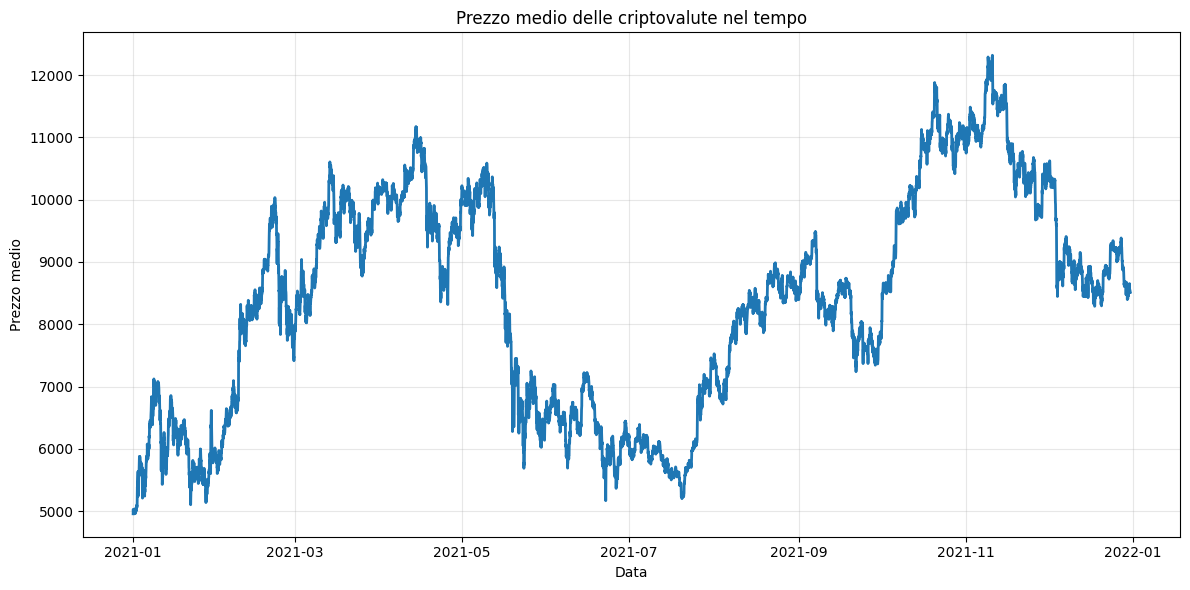

In [24]:
# Creazione del grafico
plt.figure(figsize=(12, 6))
plt.plot(crypto_prices.index, crypto_prices.mean(axis=1), label='Prezzo Medio', linewidth=2)

# Personalizzazione del grafico
plt.title('Prezzo medio delle criptovalute nel tempo')
plt.xlabel('Data')
plt.ylabel('Prezzo medio')
plt.grid(alpha=0.3)
plt.tight_layout()

# Mostra il grafico
plt.show()

In [25]:
# crypto_prices.to_csv(f'{list(crypto_prices.columns)}_USDT_timeframe_{timeframe_download}_start_date_{start_date}_end_date_{end_date}.csv')

In [26]:
# Parametri fissi
initial_liquidity = 100

# Parametri variabili
timeframe = 24*15
timeframe_grid_search = -1 # un valore di -1 significa che diventa uguale a timeframe nella strategia; qui potrei anche mettere direttamente timeframe_grid_search=timeframe, ma in generale nella macro grid search che farò successivamente devo fare così
mobile_window = 24*2
weighting_factor = 0
coef_liquidity_out = 2
coef_liquidity_in = 3
dynamical_variables = {
    # 'coef_liquidity_in': [0, 1, np.inf],
    # 'coef_liquidity_out': [0, 1, np.inf],
    # # 'func_monitor': [mstd_returns_prices, ma_returns_prices],
    # 'mobile_window': [48, 24*7],
    # 'timeframe': [24, 24*7, 24*14],
    # 'weighting_factor': [-1, 0, 1],
    # 'window_grid_search': [24*7, 24*14, 24*30]

} # VARIABILI DA NON METTERE IN dynamical_variables: dynamical_variables; timeframe_grid_search; timeframe
window_grid_search = 24*15 # Consigliabile averlo maggiore di timeframe_grid_search (se "timeframe_grid_search" non compare in dynamical_variables), perchè altrimenti di fatto la grid search effettua delle mini-simulazioni in cui non ribilancia mai e il fattore di rendimento totale risulterà sempre uguale per tutte le combinazioni della grid search in questione
func_monitor = ma_returns_prices

df_results = simulate_trading_strategy_2(crypto_prices, initial_liquidity, initial_allocations, timeframe, timeframe_grid_search, mobile_window, weighting_factor, coef_liquidity_out, coef_liquidity_in, dynamical_variables, window_grid_search, func_monitor)
df_results

,timestamp,liquidity,portfolio_value,avg_metric,sub_metric_up,sub_return_up,MA_sub_return_up,price_BTC,qty_BTC,value_BTC,metric_BTC,last_ext_type_BTC,last_ext_value_BTC,price_ETH,qty_ETH,value_ETH,metric_ETH,last_ext_type_ETH,last_ext_value_ETH,price_SOL,qty_SOL,value_SOL,metric_SOL,last_ext_type_SOL,last_ext_value_SOL,price_DOGE,qty_DOGE,value_DOGE,metric_DOGE,last_ext_type_DOGE,last_ext_value_DOGE,price_LINK,qty_LINK,value_LINK,metric_LINK,last_ext_type_LINK,last_ext_value_LINK,price_AXS,qty_AXS,value_AXS,metric_AXS,last_ext_type_AXS,last_ext_value_AXS,last_ext_type_avg,last_ext_value_avg,last_ext_type_sub_up,last_ext_value_sub_up
0,2021-01-01 00:00:00,0.0,100.000000,NaN,NaN,NaN,NaN,28995.13,0.000575,16.666667,NaN,None,NaN,734.07,0.022704,16.666667,NaN,None,NaN,1.5442,10.793075,16.666667,NaN,None,NaN,0.004679,3562.166937,16.666667,NaN,None,NaN,11.2812,1.477384,16.666667,NaN,None,NaN,0.53441,31.187041,16.666667,NaN,None,NaN,None,NaN,None,NaN
1,2021-01-01 01:00:00,0.0,101.342501,NaN,NaN,NaN,NaN,29409.99,0.000575,16.905132,NaN,None,NaN,748.28,0.022704,16.989297,NaN,None,NaN,1.5734,10.793075,16.981824,NaN,None,NaN,0.004737,3562.166937,16.872204,NaN,None,NaN,11.4735,1.477384,16.950768,NaN,None,NaN,0.53366,31.187041,16.643276,NaN,None,NaN,None,NaN,None,NaN
2,2021-01-01 02:00:00,0.0,101.477428,NaN,NaN,NaN,NaN,29194.65,0.000575,16.781353,NaN,None,NaN,744.06,0.022704,16.893484,NaN,None,NaN,1.5872,10.793075,17.130769,NaN,None,NaN,0.004755,3562.166937,16.938460,NaN,None,NaN,11.5773,1.477384,17.104120,NaN,None,NaN,0.53321,31.187041,16.629242,NaN,None,NaN,None,NaN,None,NaN
3,2021-01-01 03:00:00,0.0,102.659037,NaN,NaN,NaN,NaN,29278.40,0.000575,16.829493,NaN,None,NaN,744.82,0.022704,16.910740,NaN,None,NaN,1.6029,10.793075,17.300220,NaN,None,NaN,0.004978,3562.166937,17.732823,NaN,None,NaN,11.5006,1.477384,16.990805,NaN,None,NaN,0.54173,31.187041,16.894956,NaN,None,NaN,None,NaN,None,NaN
4,2021-01-01 04:00:00,0.0,102.115284,NaN,NaN,NaN,NaN,29220.31,0.000575,16.796102,NaN,None,NaN,742.29,0.022704,16.853297,NaN,None,NaN,1.6022,10.793075,17.292665,NaN,None,NaN,0.004894,3562.166937,17.432533,NaN,None,NaN,11.4575,1.477384,16.927130,NaN,None,NaN,0.53912,31.187041,16.813558,NaN,None,NaN,None,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8719,2021-12-30 20:00:00,0.0,542.041127,-0.000782,-0.000782,0.133658,0.001846,47203.16,0.000585,27.623962,-0.000246,min,-0.000246,3724.78,0.002694,10.035573,-0.000544,min,-0.000544,173.1900,0.882283,152.802654,-0.000911,min,-0.000911,0.171100,217.317477,37.183020,-0.000583,min,-0.000583,19.8700,12.598728,250.336729,-0.001140,min,-0.001140,95.08000,0.673740,64.059188,-0.001265,min,-0.001265,min,-0.000782,max,0.001846
8720,2021-12-30 21:00:00,0.0,544.106509,-0.000507,NaN,0.000000,-0.001084,47300.00,0.000585,27.680634,-0.000095,max,-0.000095,3736.93,0.002694,10.068309,-0.000367,max,-0.000367,173.2000,0.882283,152.811476,-0.000618,max,-0.000618,0.171800,217.317477,37.335143,-0.000285,max,-0.000285,19.9900,12.598728,251.848576,-0.000559,max,-0.000559,95.53000,0.673740,64.362371,-0.001121,max,-0.001121,max,-0.000507,max,0.001846
8721,2021-12-30 22:00:00,0.0,540.199687,-0.000701,-0.000701,-0.103633,-0.001278,47084.88,0.000585,27.554743,-0.000244,min,-0.000244,3703.83,0.002694,9.979128,-0.000571,min,-0.000571,171.6800,0.882283,151.470406,-0.000889,min,-0.000889,0.171000,217.317477,37.161289,-0.000346,min,-0.000346,19.8600,12.598728,250.210742,-0.000796,min,-0.000796,94.73000,0.673740,63.823379,-0.001358,min,-0.001358,min,-0.000701,min,-0.001278
8722,2021-12-30 23:00:00,0.0,542.062076,-0.000479,-0.001002,0.430420,0.005301,47120.87,0.000585,27.575805,-0.000168,max,-0.000168,3709.27,0.002694,9.993785,-0.000443,max,-0.000443,172.5200,0.882283,152.211524,-0.000543,max,-0.000543,0.171100,217.317477,37.183020,-0.000310,max,-0.000310,19.9300,12.598728,251.092653,-0.000410,max,

In [27]:
df_results['portfolio_value'].iloc[-1] / df_results['portfolio_value'].iloc[0]

5.408209695305189

In [28]:
df_results['portfolio_value'].max() / df_results['portfolio_value'].iloc[0]

6.488655158197133

In [29]:
df_results['portfolio_value'].max(), df_results['portfolio_value'].iloc[-1]

(648.8655158197131, 540.8209695305187)

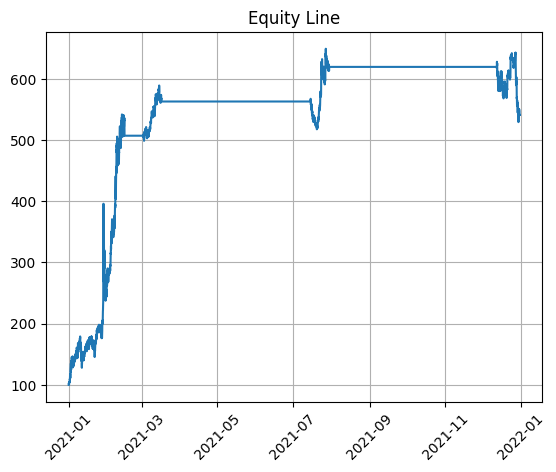

In [30]:
plt.title('Equity Line')
plt.xticks(rotation=45)
plt.grid()
plt.plot(df_results['timestamp'], df_results['portfolio_value']);

In [31]:
mdp.calcola_principali_metriche(portfolio_values=df_results['portfolio_value'])

{'Total Return %': 440.82096953051877,
 'Max Drawdown %': 40.044243086697435,
 'Volatility': 0.13356808134734907,
 'Sharpe Ratio': 0.4303630378546233,
 'Sortino Ratio': 0.6842550430843386,
 'Calmar Ratio': 11.008348155716748,
 'Profit Factor': 'Non calcolabile: dati insufficienti, servono prezzi e quantità di bitcoin posseduti',
 'PnL': 'Non calcolabile: dati insufficienti, servono prezzi e quantità di bitcoin posseduti'}

In [32]:
calcola_rendimento_portafoglio_ideale_multicrypto([crypto_prices[crypto] for crypto in initial_allocations.keys() if crypto != 'liquidity'], initial_liquidity, [token_iniziali for token_iniziali in initial_allocations.values()], 0, 0, 0, 0)

[4.283913220607839e+59, 9.620487367455475e+61]

# Grid search

In [33]:
# Parametri fissi
initial_allocations = {'liquidity': 0, 'BTC': 1/6, 'ETH': 1/6, 'SOL': 1/6, 'DOGE': 1/6, 'LINK': 1/6, 'AXS': 1/6}
initial_liquidity = 100
sort_quantity = 'fattore_rendimento_totale'

In [ ]:
# Dizionario dei parametri per la grid search
param_grid = {
    'coef_liquidity_in': [0, 1, 5],
    'coef_liquidity_out': [0, 1, 5],
    'dynamical_variables': [{}, {'weighting_factor': [0, 0.5, 1]}], # {'func_monitor': [ma_returns_prices, mstd_returns_prices]}, {'coef_liquidity_in': [0, 1, np.inf], 'coef_liquidity_out': [0, 1, np.inf]}, {'coef_liquidity_in': [0, 1, np.inf], 'coef_liquidity_out': [0, 1, np.inf], 'weighting_factor': [-1, 0, 1]}
    'func_monitor': [ma_returns_prices, mstd_returns_prices],
    'mobile_window': [1, 24, 24*7],
    'timeframe': [24*7, 24*8, 24*9, 24*10, 24*11, 24*12, 24*13, 24*14, 24*15, 24*16, 24*17, 24*18, 24*19, 24*20],
    'timeframe_grid_search': [-1, 24*2], # un valore di -1 significa che diventa uguale a timeframe nella strategia
    'weighting_factor': [0, 0.5, 1],
    'window_grid_search': [24*7, 24*14, 24*15]
}

# Genera tutte le combinazioni di parametri
grid_params = list(ParameterGrid(param_grid))

skip_conditions = [] # Qua salvo le condizioni per cui è inutile fare il calcolo perchè il risultato sarebbe uguale a un'altra combinazione già vista

for comb in grid_params:
    condition = len(comb['dynamical_variables']) == 0 and comb['window_grid_search'] != param_grid['window_grid_search'][0] or len(comb['dynamical_variables']) == 0 and comb['timeframe_grid_search'] != param_grid['timeframe_grid_search'][0] or any([param in comb['dynamical_variables'].keys() and comb[param] != param_grid[param][0] for param in param_grid.keys()]) # riguardo alla condizione con "any": se una variabile cambia dinamicamente, salto tutte le combinazioni in cui la stessa variabile in versione statica assume valori diversi dal primo, perchè tanto cambia dinamicamente quel parametro (in realtà non è del tutto uguale perchè all'inizio conta il valore iniziale del parametro, è solo dalla prima mini grid search che cambia in modo dinamico, ma considero trascurabile l'effetto)
    skip_conditions.append(condition)

save_each = True
start = 1
file = pd.read_csv('Risultati 2 Rotazione multi-asset con medie mobili.csv') # Leggo il file e lo mando a grid_search_rebalancing_2 per evitare di calcolare combinazioni già presenti nel file

# Esegue la grid search e visualizza i nuovi risultati
risultati_df_ordinati = grid_search_rebalancing_2(crypto_prices, grid_params, initial_allocations, initial_liquidity, skip_conditions, sort_quantity, save_each, start, file)
risultati_df_ordinati['func_monitor'] = risultati_df_ordinati['func_monitor'].apply(
            lambda x: x.__name__ if callable(x) else x
        )


Inizio iterazione 1/27216
Parametri: {'coef_liquidity_in': '0', 'coef_liquidity_out': '0', 'dynamical_variables': '{}', 'func_monitor': 'ma_returns_prices', 'mobile_window': '1', 'timeframe': '168', 'timeframe_grid_search': '-1', 'weighting_factor': '0', 'window_grid_search': '168'}
Salto questa combinazione perchè è già presente nel csv...


Inizio iterazione 2/27216
Parametri: {'coef_liquidity_in': '0', 'coef_liquidity_out': '0', 'dynamical_variables': '{}', 'func_monitor': 'ma_returns_prices', 'mobile_window': '1', 'timeframe': '168', 'timeframe_grid_search': '-1', 'weighting_factor': '0', 'window_grid_search': '336'}
Salto questa combinazione perchè sarebbe uguale a un'altra già vista...


Inizio iterazione 3/27216
Parametri: {'coef_liquidity_in': '0', 'coef_liquidity_out': '0', 'dynamical_variables': '{}', 'func_monitor': 'ma_returns_prices', 'mobile_window': '1', 'timeframe': '168', 'timeframe_grid_search': '-1', 'weighting_factor': '0', 'window_grid_search': '360'}
Salto questa

In [ ]:
print('risultati_df_ordinati:')
risultati_df_ordinati

risultati_df_ordinati:


,coef_liquidity_in,coef_liquidity_out,dynamical_variables,func_monitor,mobile_window,timeframe,timeframe_grid_search,weighting_factor,window_grid_search,fattore_rendimento_totale,volatility,max_drawdown,sharpe_ratio,sortino_ratio,calmar_ratio
0,5.5,5.5,{},mstd_returns_prices,720,336,-1,0.5,168,13.65305,0.254685,68.798044,0.422783,0.709305,18.391585


In [ ]:
# Funzione per confrontare due righe cella per cella:
def rows_are_close(row1, row2, atol=1e-10):
    """
    Confronta due righe (pandas Series) cella per cella.
    Se la cella è numerica (o convertibile in float) usa np.isclose,
    altrimenti usa il confronto diretto.
    """
    for col in row1.index:
        a = row1[col]
        b = row2[col]
        # Proviamo a convertire a float: se funziona, assumiamo sia numerico.
        try:
            a_float = float(a)
            b_float = float(b)
        except (ValueError, TypeError):
            # Se la conversione non va a buon fine, confrontiamo direttamente
            if a != b:
                return False
        else:
            if not np.isclose(a_float, b_float, atol=atol):
                return False
    return True

# Funzione per filtrare il DataFrame eliminando righe "quasi duplicate"
def filter_duplicates(df, atol=1e-10):
    """
    Itera su df e conserva solo le righe che non risultano (quasi) duplicate.
    """
    filtered_indices = []
    for i, row in df.iterrows():
        duplicate_found = False
        # Confronta la riga corrente con quelle già approvate (con indice in filtered_indices)
        for j in filtered_indices:
            if rows_are_close(df.loc[j], row, atol=atol):
                duplicate_found = True
                break
        if not duplicate_found:
            filtered_indices.append(i)
    return df.loc[filtered_indices].reset_index(drop=True)

In [ ]:
if not save_each:
    csv_name = 'Risultati 2 Rotazione multi-asset con medie mobili'

    # Converti eventuali colonne di tipo dict in stringa
    for col in risultati_df_ordinati.columns:
        if risultati_df_ordinati[col].apply(lambda x: isinstance(x, dict)).any():
            risultati_df_ordinati[col] = risultati_df_ordinati[col].apply(lambda x: str(x))

    # Carica i vecchi risultati dal file CSV
    try:
        old_results = pd.read_csv(f'{csv_name}.csv')
    except FileNotFoundError:
        old_results = pd.DataFrame()  # Crea un DataFrame vuoto se il file non esiste

    # Concatena i vecchi e nuovi risultati, rimuovendo i duplicati esatti
    total_results = pd.concat([old_results, risultati_df_ordinati]).drop_duplicates().reset_index(drop=True)

    # Filtra le righe "quasi duplicate" usando la funzione custom
    # total_results = filter_duplicates(total_results, atol=1e-10)

    total_results = total_results.sort_values(by='fattore_rendimento_totale', ascending=False)
    print('total_results:')
    display(total_results)

    # Salva i risultati aggiornati nel file CSV senza l'indice
    total_results.to_csv(f'{csv_name}.csv', index=False)
else:
    total_results = pd.read_csv(f'{csv_name}.csv')

    # Filtra le righe "quasi duplicate"
    # total_results = filter_duplicates(total_results, atol=1e-10)
    total_results = total_results.sort_values(by='fattore_rendimento_totale', ascending=False)
    print('Salvo nuovamente i risultati in csv sovrascrivendo il file precedente, nel caso ci fossero duplicati')
    total_results.to_csv(f'{csv_name}.csv', index=False)
    print('total_results:')
    display(total_results)

Salvo nuovamente i risultati in csv sovrascrivendo il file precedente, nel caso ci fossero duplicati
total_results:


,coef_liquidity_in,coef_liquidity_out,dynamical_variables,func_monitor,mobile_window,timeframe,timeframe_grid_search,weighting_factor,window_grid_search,fattore_rendimento_totale,volatility,max_drawdown,sharpe_ratio,sortino_ratio,calmar_ratio
0,0.5,0.5,{},mstd_returns_prices,12,336,-1,0.5,168,584.680223,0.312325,64.151079,0.738917,1.344669,909.852541
1,0.5,1.5,{},mstd_returns_prices,12,336,-1,0.5,168,561.990908,0.311224,64.151079,0.736776,1.340011,874.483978
2,0.0,0.0,"{'weighting_factor': [0, 0.5, 1]}",ma_returns_prices,48,336,-1,0.0,720,553.135050,0.351338,68.194708,0.688079,1.250061,809.645007
3,0.0,0.0,"{'weighting_factor': [0, 0.5, 1]}",ma_returns_prices,48,336,-1,0.0,360,551.411699,0.348896,68.194708,0.690294,1.253264,807.117903
4,0.0,inf,{},mstd_ma_returns_prices,168,336,-1,1.0,360,543.160563,0.416453,70.248045,0.631897,1.230622,771.780286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12007,inf,inf,{},ma_ma_returns_prices,336,168,-1,-1.0,168,0.590056,0.150105,79.583430,-0.026005,-0.037898,-0.515112
12008,inf,3.0,{},ma_ma_returns_prices,336,168,-1,-1.0,168,0.546440,0.150850,81.092590,-0.039835,-0.058133,-0.559311
12009,inf,3.0,{},ma_ma_returns_prices,336,336,-1,-1.0,168,0.406972,0.154141,85.787925,-0.090936,-0.132922,-0.691272
12010,inf,10.0,{},ma_ma_returns_prices,336,336,-1,-1.0,168,0.398157,0.154045,86.095755,-0.095195,-0.138968,-0.699039


In [ ]:
# Assicuriamoci che tutte le colonne di parametri siano rappresentate come stringhe
df_params = total_results[param_grid.keys()].astype(str)

# Contiamo quante volte compare ogni combinazione unica di parametri
param_counts = df_params.value_counts()

# Se ci sono duplicati (cioè combinazioni che appaiono più volte), qualcosa non va
if (param_counts > 1).any():
    print("ATTENZIONE: Esistono combinazioni di parametri duplicate con risultati diversi!")
else:
    print("Tutto OK: ogni combinazione di parametri è unica.")

# Se vuoi vedere le combinazioni duplicate
duplicates = param_counts[param_counts > 1]
if not duplicates.empty:
    print("Combinazioni duplicate trovate:\n", duplicates)

ATTENZIONE: Esistono combinazioni di parametri duplicate con risultati diversi!
Combinazioni duplicate trovate:
 coef_liquidity_in  coef_liquidity_out  dynamical_variables  func_monitor         mobile_window  timeframe  timeframe_grid_search  weighting_factor  window_grid_search
5.5                5.5                 {}                   mstd_returns_prices  720            336        -1                     0.5               168                   2
Name: count, dtype: int64


In [ ]:
# Verifico che non ci siano combinazioni di parametri uguali con risultati diversi (altrimenti ci sarebbe qualcosa di sbagliato): il value_counts sui soli parametri deve darmi tutti 1
total_results[param_grid.keys()].value_counts()

coef_liquidity_in  coef_liquidity_out  dynamical_variables                func_monitor            mobile_window  timeframe  timeframe_grid_search  weighting_factor  window_grid_search
5.5                5.5                 {}                                 mstd_returns_prices     720            336        -1                      0.5              168                   2
0.0                0.0                 {'weighting_factor': [0, 0.5, 1]}  ma_returns_prices       48             168        -1                      0.0              360                   1
4.5                3.5                 {}                                 mstd_ma_returns_prices  12             336        -1                     -0.5              168                   1
                                                                                                  1              168        -1                     -0.5              168                   1
                                                            

In [ ]:
total_results[(total_results['weighting_factor'] == 0) & (total_results['func_monitor'] == 'ma_returns_prices') & (total_results['coef_liquidity_in'] == 1) & (total_results['coef_liquidity_out'] == 1) & (total_results['dynamical_variables'] == "{'weighting_factor': [-1, 0, 1]}") & (total_results['mobile_window'] == 336)].sort_values(by='fattore_rendimento_totale', ascending=False)

,coef_liquidity_in,coef_liquidity_out,dynamical_variables,func_monitor,mobile_window,timeframe,timeframe_grid_search,weighting_factor,window_grid_search,fattore_rendimento_totale,volatility,max_drawdown,sharpe_ratio,sortino_ratio,calmar_ratio


In [ ]:
df_over_100 = total_results[total_results['fattore_rendimento_totale'] > 100]
df_over_100

,coef_liquidity_in,coef_liquidity_out,dynamical_variables,func_monitor,mobile_window,timeframe,timeframe_grid_search,weighting_factor,window_grid_search,fattore_rendimento_totale,volatility,max_drawdown,sharpe_ratio,sortino_ratio,calmar_ratio
0,0.5,0.5,{},mstd_returns_prices,12,336,-1,0.5,168,584.680223,0.312325,64.151079,0.738917,1.344669,909.852541
1,0.5,1.5,{},mstd_returns_prices,12,336,-1,0.5,168,561.990908,0.311224,64.151079,0.736776,1.340011,874.483978
2,0.0,0.0,"{'weighting_factor': [0, 0.5, 1]}",ma_returns_prices,48,336,-1,0.0,720,553.135050,0.351338,68.194708,0.688079,1.250061,809.645007
3,0.0,0.0,"{'weighting_factor': [0, 0.5, 1]}",ma_returns_prices,48,336,-1,0.0,360,551.411699,0.348896,68.194708,0.690294,1.253264,807.117903
4,0.0,inf,{},mstd_ma_returns_prices,168,336,-1,1.0,360,543.160563,0.416453,70.248045,0.631897,1.230622,771.780286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,5.5,4.5,{},ma_returns_prices,720,336,-1,0.5,168,100.655296,0.278653,63.453275,0.613280,1.076729,157.053037
585,inf,0.0,{},ma_returns_prices,48,336,-1,0.5,360,100.622070,0.318197,69.235284,0.570278,1.012663,143.889163
586,1.5,3.5,{},mstd_ma_returns_prices,720,336,-1,0.5,168,100.505778,0.259647,72.436550,0.642671,1.077285,137.369570
587,inf,0.0,"{'weighting_factor': [0, 0.5, 1]}",ma_returns_prices,48,336,-1,0.0,720,100.085026,0.312330,68.194708,0.575074,1.021215,145.297236


In [ ]:
df_over_100[['dynamical_variables', 'func_monitor']].value_counts()

dynamical_variables                                                                                                                      func_monitor          
{}                                                                                                                                       ma_returns_prices         256
                                                                                                                                         mstd_returns_prices       151
                                                                                                                                         mstd_ma_returns_prices     98
{'weighting_factor': [0, 0.5, 1]}                                                                                                        ma_returns_prices          29
{'coef_liquidity_in': [0, 1, inf], 'coef_liquidity_out': [0, 1, inf]}                                                                    ma_returns_prices          15
{}   

In [ ]:
mean_values = df_over_100.select_dtypes(include=['number']).mean()
mean_values

coef_liquidity_in                   inf
coef_liquidity_out                  inf
mobile_window                403.089983
timeframe                    306.091681
timeframe_grid_search          0.560272
weighting_factor               0.339559
window_grid_search           231.320883
fattore_rendimento_totale    169.213743
volatility                     0.291681
max_drawdown                  64.718243
sharpe_ratio                   0.646390
sortino_ratio                  1.137287
calmar_ratio                 261.567767
dtype: float64

In [ ]:
median_values = df_over_100.select_dtypes(include=['number']).median()
median_values

coef_liquidity_in              2.500000
coef_liquidity_out             2.500000
mobile_window                336.000000
timeframe                    336.000000
timeframe_grid_search         -1.000000
weighting_factor               0.500000
window_grid_search           168.000000
fattore_rendimento_totale    147.540079
volatility                     0.284965
max_drawdown                  64.151079
sharpe_ratio                   0.649242
sortino_ratio                  1.116440
calmar_ratio                 232.682322
dtype: float64

In [ ]:
# Cerco il sottoinsieme di dati di df_over_100 per cui è massimizzato il rapporto tra il numero di dati considerati e la deviazione standard del fattore_rendimento_totale, così da farmi un'idea di quali sono i parametri che tendono a dare risultati alti e in un intorno ristretto di valori

def find_optimal_subset(df, target_col):
    """
    Trova il sottoinsieme di dati che massimizza il rapporto tra
    il numero di dati presenti e la deviazione standard dei valori
    della colonna target_col.
    """
    # Ordina il DataFrame in base ai valori della colonna target
    df_sorted = df.sort_values(by=target_col)
    
    best_ratio = -np.inf
    best_subset = None
    best_threshold = None
    
    # Itera su possibili soglie
    for threshold in df_sorted[target_col].unique():
        subset = df_sorted[df_sorted[target_col] >= threshold]
        subset_size = len(subset)
        
        if subset_size > 1:  # Evita divisioni per zero o calcoli su un singolo elemento
            std_dev = subset[target_col].std()
            if std_dev > 0:
                ratio = subset_size / std_dev
                if ratio > best_ratio:
                    best_ratio = ratio
                    best_subset = subset
                    best_threshold = threshold
    
    return best_subset, best_threshold, best_ratio

# Utilizzo della funzione
optimal_subset, optimal_threshold, optimal_ratio = find_optimal_subset(df_over_100, 'fattore_rendimento_totale')

print(f"Soglia ottimale: {optimal_threshold}")
print(f"Rapporto ottimale (dimensione/std): {optimal_ratio}")
print(f"Dimensione del sottoinsieme ottimale: {len(optimal_subset)}")
optimal_subset.sort_values(by='fattore_rendimento_totale', ascending=False)

Soglia ottimale: 100.03235060383538
Rapporto ottimale (dimensione/std): 7.531968534308657
Dimensione del sottoinsieme ottimale: 589


,coef_liquidity_in,coef_liquidity_out,dynamical_variables,func_monitor,mobile_window,timeframe,timeframe_grid_search,weighting_factor,window_grid_search,fattore_rendimento_totale,volatility,max_drawdown,sharpe_ratio,sortino_ratio,calmar_ratio
0,0.5,0.5,{},mstd_returns_prices,12,336,-1,0.5,168,584.680223,0.312325,64.151079,0.738917,1.344669,909.852541
1,0.5,1.5,{},mstd_returns_prices,12,336,-1,0.5,168,561.990908,0.311224,64.151079,0.736776,1.340011,874.483978
2,0.0,0.0,"{'weighting_factor': [0, 0.5, 1]}",ma_returns_prices,48,336,-1,0.0,720,553.135050,0.351338,68.194708,0.688079,1.250061,809.645007
3,0.0,0.0,"{'weighting_factor': [0, 0.5, 1]}",ma_returns_prices,48,336,-1,0.0,360,551.411699,0.348896,68.194708,0.690294,1.253264,807.117903
4,0.0,inf,{},mstd_ma_returns_prices,168,336,-1,1.0,360,543.160563,0.416453,70.248045,0.631897,1.230622,771.780286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,5.5,4.5,{},ma_returns_prices,720,336,-1,0.5,168,100.655296,0.278653,63.453275,0.613280,1.076729,157.053037
585,inf,0.0,{},ma_returns_prices,48,336,-1,0.5,360,100.622070,0.318197,69.235284,0.570278,1.012663,143.889163
586,1.5,3.5,{},mstd_ma_returns_prices,720,336,-1,0.5,168,100.505778,0.259647,72.436550,0.642671,1.077285,137.369570
587,inf,0.0,"{'weighting_factor': [0, 0.5, 1]}",ma_returns_prices,48,336,-1,0.0,720,100.085026,0.312330,68.194708,0.575074,1.021215,145.297236


In [ ]:
optimal_subset.select_dtypes(include=['number']).mean()

coef_liquidity_in                   inf
coef_liquidity_out                  inf
mobile_window                403.089983
timeframe                    306.091681
timeframe_grid_search          0.560272
weighting_factor               0.339559
window_grid_search           231.320883
fattore_rendimento_totale    169.213743
volatility                     0.291681
max_drawdown                  64.718243
sharpe_ratio                   0.646390
sortino_ratio                  1.137287
calmar_ratio                 261.567767
dtype: float64

In [ ]:
optimal_subset.select_dtypes(include=['number']).median()

coef_liquidity_in              2.500000
coef_liquidity_out             2.500000
mobile_window                336.000000
timeframe                    336.000000
timeframe_grid_search         -1.000000
weighting_factor               0.500000
window_grid_search           168.000000
fattore_rendimento_totale    147.540079
volatility                     0.284965
max_drawdown                  64.151079
sharpe_ratio                   0.649242
sortino_ratio                  1.116440
calmar_ratio                 232.682322
dtype: float64

In [ ]:
total_results[:50]

,coef_liquidity_in,coef_liquidity_out,dynamical_variables,func_monitor,mobile_window,timeframe,timeframe_grid_search,weighting_factor,window_grid_search,fattore_rendimento_totale,volatility,max_drawdown,sharpe_ratio,sortino_ratio,calmar_ratio
0,0.5,0.5,{},mstd_returns_prices,12,336,-1,0.5,168,584.680223,0.312325,64.151079,0.738917,1.344669,909.852541
1,0.5,1.5,{},mstd_returns_prices,12,336,-1,0.5,168,561.990908,0.311224,64.151079,0.736776,1.340011,874.483978
2,0.0,0.0,"{'weighting_factor': [0, 0.5, 1]}",ma_returns_prices,48,336,-1,0.0,720,553.135050,0.351338,68.194708,0.688079,1.250061,809.645007
3,0.0,0.0,"{'weighting_factor': [0, 0.5, 1]}",ma_returns_prices,48,336,-1,0.0,360,551.411699,0.348896,68.194708,0.690294,1.253264,807.117903
4,0.0,inf,{},mstd_ma_returns_prices,168,336,-1,1.0,360,543.160563,0.416453,70.248045,0.631897,1.230622,771.780286
5,0.5,2.5,{},mstd_returns_prices,12,336,-1,0.5,168,539.301593,0.310121,64.151079,0.734474,1.334998,839.115415
6,1.0,1.0,"{'coef_liquidity_in': [0, 1, inf], 'coef_liqui...",ma_returns_prices,48,336,24,0.0,720,533.224481,0.350842,69.235284,0.685089,1.245876,768.718568
7,0.5,3.5,{},mstd_returns_prices,12,336,-1,0.5,168,516.612278,0.309014,64.151079,0.732000,1.329607,803.746852
8,0.5,4.5,{},mstd_returns_prices,12,336,-1,0.5,168,493.922964,0.307901,64.151079,0.729338,1.323809,768.378289
9,0.5,5.5,{},mstd_returns_prices,12,336,-1,0.5,168,471.233649,0.306782,64.151079,0.726471,1.317572,733.009726


In [ ]:
total_results[-50:]

,coef_liquidity_in,coef_liquidity_out,dynamical_variables,func_monitor,mobile_window,timeframe,timeframe_grid_search,weighting_factor,window_grid_search,fattore_rendimento_totale,volatility,max_drawdown,sharpe_ratio,sortino_ratio,calmar_ratio
11962,inf,0.0,{},ma_mstd_returns_prices,48,168,-1,-1.0,360,0.954513,0.138279,76.796956,0.059466,0.088750,-0.059230
11963,inf,10.0,{},ma_mstd_returns_prices,168,168,-1,-0.5,168,0.951064,0.111729,50.451959,0.043164,0.062966,-0.096996
11965,inf,inf,{},ma_mstd_returns_prices,48,168,-1,-1.0,360,0.945505,0.132637,74.114396,0.054158,0.080195,-0.073528
11964,inf,inf,{},ma_mstd_returns_prices,48,168,-1,-0.5,360,0.945505,0.132637,74.114396,0.054158,0.080195,-0.073528
11967,inf,inf,{},ma_mstd_returns_prices,168,168,-1,-0.5,360,0.944772,0.110508,50.136409,0.040678,0.059056,-0.110155
11966,inf,inf,{},ma_mstd_returns_prices,168,168,-1,-0.5,168,0.944772,0.110508,50.136409,0.040678,0.059056,-0.110155
11968,3.5,0.5,{},ma_ma_returns_prices,12,168,-1,-0.5,168,0.940950,0.080924,48.586272,0.018909,0.027090,-0.121537
11969,inf,3.0,{},ma_mstd_returns_prices,48,168,-1,-1.0,360,0.940354,0.135330,76.435888,0.054589,0.081250,-0.078034
11970,inf,3.0,{},ma_mstd_returns_prices,48,168,-1,-0.5,360,0.940354,0.135330,76.435888,0.054589,0.081250,-0.078034
11971,3.5,3.5,{},ma_mstd_returns_prices,48,168,-1,-0.5,168,0.939259,0.095569,59.360717,0.028959,0.041810,-0.102326


In [ ]:
total_results['fattore_rendimento_totale'].mean(), total_results['fattore_rendimento_totale'].median(), total_results['fattore_rendimento_totale'].min(), total_results['fattore_rendimento_totale'].max(), total_results['fattore_rendimento_totale'].std()

(24.10290470309369,
 8.596437176334556,
 0.3981571282412667,
 584.6802226828675,
 42.20720608955922)

In [ ]:
total_results.sort_values(by='sharpe_ratio', ascending=False).reset_index(drop=True)

,coef_liquidity_in,coef_liquidity_out,dynamical_variables,func_monitor,mobile_window,timeframe,timeframe_grid_search,weighting_factor,window_grid_search,fattore_rendimento_totale,volatility,max_drawdown,sharpe_ratio,sortino_ratio,calmar_ratio
0,inf,inf,{},ma_returns_prices,720,24,-1,0.0,168,172.972767,0.232981,52.566308,0.754082,1.290456,327.153978
1,1.5,0.5,{},mstd_returns_prices,12,336,-1,0.5,168,406.110842,0.280720,64.151079,0.751182,1.369361,631.494978
2,1.5,1.5,{},mstd_returns_prices,12,336,-1,0.5,168,374.125708,0.279301,64.151079,0.745120,1.356788,581.635904
3,3.0,3.0,{},mstd_ma_returns_prices,720,24,-1,0.0,168,39.065858,0.159183,31.672499,0.744795,1.186543,120.185839
4,5.0,5.0,{},ma_returns_prices,720,48,-1,0.0,360,93.080830,0.203948,50.343421,0.742959,1.255118,182.905391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12007,inf,inf,{},ma_ma_returns_prices,336,168,-1,-1.0,168,0.590056,0.150105,79.583430,-0.026005,-0.037898,-0.515112
12008,inf,3.0,{},ma_ma_returns_prices,336,168,-1,-1.0,168,0.546440,0.150850,81.092590,-0.039835,-0.058133,-0.559311
12009,inf,3.0,{},ma_ma_returns_prices,336,336,-1,-1.0,168,0.406972,0.154141,85.787925,-0.090936,-0.132922,-0.691272
12010,inf,10.0,{},ma_ma_returns_prices,336,336,-1,-1.0,168,0.398157,0.154045,86.095755,-0.095195,-0.138968,-0.699039


In [ ]:
total_results.sort_values(by='sortino_ratio', ascending=False).reset_index(drop=True)

,coef_liquidity_in,coef_liquidity_out,dynamical_variables,func_monitor,mobile_window,timeframe,timeframe_grid_search,weighting_factor,window_grid_search,fattore_rendimento_totale,volatility,max_drawdown,sharpe_ratio,sortino_ratio,calmar_ratio
0,10.0,3.0,{},ma_mstd_returns_prices,24,24,-1,-1.0,168,13.324205,0.153353,36.214678,0.553329,1.676739,34.030967
1,10.0,3.0,{},ma_mstd_returns_prices,24,24,-1,-0.5,168,13.477442,0.153723,36.214678,0.554534,1.660365,34.454103
2,10.0,10.0,{},ma_mstd_returns_prices,24,24,-1,-1.0,168,11.550967,0.152434,37.046915,0.528670,1.625275,28.480015
3,10.0,10.0,{},ma_mstd_returns_prices,24,24,-1,-0.5,168,11.683811,0.152806,37.046915,0.529934,1.608806,28.838598
4,10.0,inf,{},ma_mstd_returns_prices,24,24,-1,-1.0,168,10.879408,0.151899,37.046915,0.518603,1.606128,26.667289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12007,inf,inf,{},ma_ma_returns_prices,336,168,-1,-1.0,168,0.590056,0.150105,79.583430,-0.026005,-0.037898,-0.515112
12008,inf,3.0,{},ma_ma_returns_prices,336,168,-1,-1.0,168,0.546440,0.150850,81.092590,-0.039835,-0.058133,-0.559311
12009,inf,3.0,{},ma_ma_returns_prices,336,336,-1,-1.0,168,0.406972,0.154141,85.787925,-0.090936,-0.132922,-0.691272
12010,inf,10.0,{},ma_ma_returns_prices,336,336,-1,-1.0,168,0.398157,0.154045,86.095755,-0.095195,-0.138968,-0.699039


In [ ]:
total_results.sort_values(by='calmar_ratio', ascending=False).reset_index(drop=True)

,coef_liquidity_in,coef_liquidity_out,dynamical_variables,func_monitor,mobile_window,timeframe,timeframe_grid_search,weighting_factor,window_grid_search,fattore_rendimento_totale,volatility,max_drawdown,sharpe_ratio,sortino_ratio,calmar_ratio
0,0.5,0.5,{},mstd_returns_prices,12,336,-1,0.5,168,584.680223,0.312325,64.151079,0.738917,1.344669,909.852541
1,0.5,1.5,{},mstd_returns_prices,12,336,-1,0.5,168,561.990908,0.311224,64.151079,0.736776,1.340011,874.483978
2,0.5,2.5,{},mstd_returns_prices,12,336,-1,0.5,168,539.301593,0.310121,64.151079,0.734474,1.334998,839.115415
3,0.0,0.0,"{'weighting_factor': [0, 0.5, 1]}",ma_returns_prices,48,336,-1,0.0,720,553.135050,0.351338,68.194708,0.688079,1.250061,809.645007
4,0.0,0.0,"{'weighting_factor': [0, 0.5, 1]}",ma_returns_prices,48,336,-1,0.0,360,551.411699,0.348896,68.194708,0.690294,1.253264,807.117903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12007,inf,inf,{},ma_ma_returns_prices,336,168,-1,-1.0,168,0.590056,0.150105,79.583430,-0.026005,-0.037898,-0.515112
12008,inf,3.0,{},ma_ma_returns_prices,336,168,-1,-1.0,168,0.546440,0.150850,81.092590,-0.039835,-0.058133,-0.559311
12009,inf,3.0,{},ma_ma_returns_prices,336,336,-1,-1.0,168,0.406972,0.154141,85.787925,-0.090936,-0.132922,-0.691272
12010,inf,10.0,{},ma_ma_returns_prices,336,336,-1,-1.0,168,0.398157,0.154045,86.095755,-0.095195,-0.138968,-0.699039


In [ ]:
total_results.sort_values(by='max_drawdown', ascending=True).reset_index(drop=True)

,coef_liquidity_in,coef_liquidity_out,dynamical_variables,func_monitor,mobile_window,timeframe,timeframe_grid_search,weighting_factor,window_grid_search,fattore_rendimento_totale,volatility,max_drawdown,sharpe_ratio,sortino_ratio,calmar_ratio
0,0.5,2.5,{},ma_ma_returns_prices,12,168,-1,0.5,168,1.499840,0.048433,12.336576,0.266221,0.384957,4.051692
1,0.5,5.5,{},ma_ma_returns_prices,12,168,-1,-0.5,168,1.465575,0.045620,12.336576,0.265106,0.379674,3.773937
2,0.5,4.5,{},ma_ma_returns_prices,12,168,-1,0.0,168,1.472075,0.045828,12.336576,0.266904,0.382546,3.826632
3,0.5,3.5,{},ma_ma_returns_prices,12,168,-1,0.5,168,1.459540,0.045910,12.336576,0.261128,0.374526,3.725023
4,0.5,3.5,{},ma_ma_returns_prices,12,168,-1,-0.5,168,1.458543,0.045635,12.336576,0.261989,0.375284,3.716938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12007,3.0,0.0,{},ma_mstd_returns_prices,48,168,-1,1.0,360,0.601780,0.297987,86.610443,0.092085,0.151332,-0.459783
12008,1.0,1.0,"{'coef_liquidity_in': [0, 1, inf], 'coef_liqui...",ma_returns_prices,168,168,-1,0.0,360,4.931852,0.299407,87.434586,0.301604,0.487270,4.496906
12009,inf,inf,{},ma_mstd_returns_prices,48,168,-1,1.0,360,1.816589,0.333649,90.345469,0.211063,0.354002,0.903852
12010,inf,3.0,{},ma_mstd_returns_prices,48,168,-1,1.0,360,1.679244,0.342560,91.544652,0.207824,0.348280,0.741981


# Machine learning per trovare relazioni tra parametri e target

## Random forest

In [ ]:
def train_random_forest_regressor(
    risultati_df_ordinati,
    feature_cols,
    target_col,
    test_size=0.2,
    random_state=42,
    # Parametri generici della RandomForest (valori di default)
    n_estimators=100,
    criterion='squared_error',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None,
    # Valore numerico limite per sostituire np.inf
    max_val=1e9
):
    """
    Allena una RandomForestRegressor per predire 'target_col' (continuo) 
    a partire da 'feature_cols'. Sostituisce eventuali valori np.inf / -np.inf con +/- max_val.
    Mostra le importanze delle feature (anche graficamente).

    Parametri
    ---------
    risultati_df_ordinati : pd.DataFrame
        Il DataFrame con i dati (colonne di parametri e colonna target).
    feature_cols : list
        Lista di nomi di colonne da usare come feature (parametri).
    target_col : str
        Nome della colonna target (es. 'fattore_rendimento_totale').
    test_size : float
        Percentuale di dati nel test set (default 0.2 = 20%).
    random_state : int
        Seed per la riproducibilità.
    n_estimators : int
        Numero di alberi nella foresta. Default=100.
    criterion : str
        Funzione di split ('squared_error', 'absolute_error', ecc.).
    max_depth : int
        Profondità massima degli alberi, None = illimitata.
    min_samples_split : int
        Min numero di campioni per dividere un nodo.
    min_samples_leaf : int
        Min numero di campioni in un leaf node.
    min_weight_fraction_leaf : float
        Min frazione peso sample in un leaf node.
    max_features : str/int/float
        Numero di feature da considerare a ogni split.
    max_leaf_nodes : int
        Numero massimo di leaf nodes.
    min_impurity_decrease : float
        Soglia per ridurre la crescita del nodo se non migliora l'impurity.
    bootstrap : bool
        Usa il bootstrap per il campionamento.
    oob_score : bool
        Se True, calcola lo score out-of-bag.
    n_jobs : int
        Numero di job in parallelo (None=1, -1=usa tutti i core).
    verbose : int
        Livello di verbosità.
    warm_start : bool
        Se True, riusa la soluzione dell'albero precedente per addestrare uno nuovo.
    ccp_alpha : float
        Parametro di complessità di potatura Minimal Cost-Complexity.
    max_samples : int/float
        Se bootstrap=True, numero o frazione di campioni da campionare a ogni albero.
    max_val : float
        Valore con cui sostituire np.inf e -np.inf.

    Ritorna
    -------
    model : RandomForestRegressor
        Il modello allenato.
    """
    # Sostituiamo np.inf e -np.inf con +/- max_val
    for col in feature_cols:
        risultati_df_ordinati[col] = risultati_df_ordinati[col].replace([float('inf')], max_val)
        risultati_df_ordinati[col] = risultati_df_ordinati[col].replace([-float('inf')], -max_val)

    # Selezioniamo le feature e il target
    X = risultati_df_ordinati[feature_cols]
    y = risultati_df_ordinati[target_col]

    # Suddivisione train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Inizializziamo il modello di Random Forest Regressor
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        min_weight_fraction_leaf=min_weight_fraction_leaf,
        max_features=max_features,
        max_leaf_nodes=max_leaf_nodes,
        min_impurity_decrease=min_impurity_decrease,
        bootstrap=bootstrap,
        oob_score=oob_score,
        n_jobs=n_jobs,
        random_state=random_state,
        verbose=verbose,
        warm_start=warm_start,
        ccp_alpha=ccp_alpha,
        max_samples=max_samples
    )

    # Fit del modello
    model.fit(X_train, y_train)

    # Predizione sul test set
    y_pred = model.predict(X_test)

    # Metriche di valutazione
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    print(f"R^2 (test):  {r2:.4f}")
    print(f"RMSE (test): {rmse:.4f}")

    # Feature importances
    importances = model.feature_importances_
    importances_pct = 100.0 * (importances / importances.sum())

    feats_imp = pd.DataFrame({
        'feature': feature_cols,
        'importance_pct': importances_pct
    }).sort_values('importance_pct', ascending=True)

    print("\nFeature Importances (valore assoluto e percentuale):")
    display(feats_imp.sort_values('importance_pct', ascending=False))

    # Plot orizzontale delle importanze (percentuali)
    plt.figure(figsize=(8, 4))
    plt.barh(feats_imp['feature'], feats_imp['importance_pct'], color='skyblue')
    plt.xlabel('Feature Importance (%)')
    plt.title('Random Forest Feature Importances')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

    return model

In [ ]:
def normalize_dynamical_vars_dict(d: dict) -> str:
    """
    Dato un dizionario `d` (es: {'func_monitor': [<function ma_returns_prices>, <function mstd_prices>],
                                'coef_liquidity_in': [0, inf]},
    costruisce una stringa canonica, in cui:
      - le chiavi sono in ordine alfabetico;
      - ogni valore (che e' *sempre* una lista) viene ordinato come stringhe;
      - i Callable vengono sostituiti col loro nome (.__name__),
      - i float speciali (inf) vengono convertiti in "inf",
      - e si genera uno spacing coerente.

    Esempio:
      {'func_monitor': [mstd_prices, ma_returns_prices], 'coef_liquidity_in': [1, inf]}
      => "{'coef_liquidity_in': [1, inf], 'func_monitor': [ma_returns_prices, mstd_prices]}"

    NOTA: se la chiave e' vuota o la lista e' vuota, la salviamo comunque, p.es. "'chiave': []"
    """

    # 1) Copia "logica" del dict (per non modificare l'originale).
    d_copy = dict(d)

    # 2) Creiamo una mappa (key -> string list) da cui costruire poi la stringa
    str_map = {}
    for k_raw, v_raw in d_copy.items():
        # Convertiamo la chiave in str (in genere e' gia' str)
        k = str(k_raw)

        # v_raw e' *sempre* una lista (da ipotesi).
        if not isinstance(v_raw, list):
            # Se per qualche ragione non e' una list, lo trasformiamo in lista con un solo elem
            v_list = [v_raw]
        else:
            v_list = v_raw

        # Ora convertiamo i suoi elementi in string in modo coerente
        converted_elems = []
        for elem in v_list:
            if callable(elem):
                # Funzione => usiamo elem.__name__
                converted_elems.append(elem.__name__)
            elif isinstance(elem, (int, float)):
                if str(elem) == 'inf':
                    converted_elems.append('inf')
                elif str(elem) == '-inf':
                    converted_elems.append('-inf')
                else:
                    converted_elems.append(str(elem))
            else:
                # Altri tipi (str, None, ecc.)
                converted_elems.append(str(elem))

        # Ordiniamo la lista di stringhe
        converted_elems.sort()
        str_map[k] = converted_elems

    # 3) Ordiniamo le chiavi e costruiamo la stringa finale
    sorted_keys = sorted(str_map.keys())
    parts = []
    for k in sorted_keys:
        # costruiamo p.es. "'coef_liquidity_in': [1,inf]"
        lista = str_map[k]
        # costruiamo "val1, val2, val3" con gli spazi
        joined_vals = ", ".join(lista)
        part = f"'{k}': [{joined_vals}]"
        parts.append(part)

    joined = ", ".join(parts)
    final_str = f"{{{joined}}}"
    return final_str


def flatten_dynamical_variables(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
    """
    Trasforma la colonna 'col_name' (che contiene sempre un dict,
    i cui valori sono SEMPRE liste di possibili tipi eterogenei)
    in una singola colonna 'dynamical_vars_str' di tipo string,
    uniformata con normalize_dynamical_vars_dict().

    Se per qualche riga 'col_name' non e' un dict, lo convertiamo in str() generica.
    """

    new_col_name = "dynamical_vars_str"
    new_col_values = []

    for val in df[col_name]:
        if isinstance(val, dict):
            # Normalizziamo il dict
            s = normalize_dynamical_vars_dict(val)
            new_col_values.append(s)
        else:
            # Non e' un dict (puo' essere None, o un residuo)
            new_col_values.append(str(val))

    df_out = df.copy()
    df_out[new_col_name] = new_col_values
    df_out.drop(columns=[col_name], inplace=True)
    return df_out

def run_training_with_dynamical_vars(risultati_df_ordinati):
    """
    Esempio di pipeline che:
      1) Converte la colonna 'dynamical_variables' in 'dynamical_vars_str'
         con normalizzazione.
      2) (Opzionale) Trasforma 'func_monitor' in stringa se esiste.
      3) Identifica tutte le colonne object (comprese dynamical_vars_str e func_monitor)
         e le One-Hot-encoda.
      4) Esegue la train_random_forest_regressor (R^2 e feature importance).
    """
    # 1) Flatten la colonna "dynamical_variables" => 'dynamical_vars_str'
    df_flat = flatten_dynamical_variables(risultati_df_ordinati, 'dynamical_variables')

    # 2) Se c'e' la colonna 'func_monitor', la convertiamo in string (nome funzione)
    if 'func_monitor' in df_flat.columns:
        df_flat['func_monitor'] = df_flat['func_monitor'].apply(
            lambda x: x.__name__ if callable(x) else str(x)
        )

    # 3) Trova colonne di tipo object su cui fare one-hot
    cat_cols = []
    for c in df_flat.columns:
        if df_flat[c].dtype == object:
            cat_cols.append(c)

    # Escludi eventuali target object
    target_cols = ['fattore_rendimento_totale', 'volatility',
                   'calmar_ratio', 'sortino_ratio', 'sharpe_ratio', 'max_drawdown']
    cat_cols = [c for c in cat_cols if c not in target_cols]

    # 4) One-hot encoding
    oh = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    arr_encoded = oh.fit_transform(df_flat[cat_cols].astype(str))
    oh_cols = oh.get_feature_names_out(cat_cols)

    df_enc = pd.DataFrame(arr_encoded, columns=oh_cols, index=df_flat.index)

    # Concateniamo
    df_prep = pd.concat([df_flat.drop(columns=cat_cols), df_enc], axis=1)

    # 5) Selezioniamo le feature e il target
    target = 'fattore_rendimento_totale'
    exclude = ['fattore_rendimento_totale', 'volatility', 'calmar_ratio',
               'sortino_ratio', 'sharpe_ratio', 'max_drawdown']
    feature_cols = [c for c in df_prep.columns if c not in exclude]

    # 6) Allena la Random Forest
    model = train_random_forest_regressor(
        risultati_df_ordinati=df_prep,
        feature_cols=feature_cols,
        target_col=target,
        test_size=0.2,
        random_state=42,
        n_estimators=1000,
        max_depth=None,
        verbose=0,
        max_val=1e9
    )

    return model, df_prep

### Risultati random forest

R^2 (test):  0.8083
RMSE (test): 20.0128

Feature Importances (valore assoluto e percentuale):


,feature,importance_pct
2,mobile_window,29.468078
5,weighting_factor,21.435914
3,timeframe,9.640466
0,coef_liquidity_in,8.894971
1,coef_liquidity_out,7.062598
11,func_monitor_mstd_returns_prices,4.939602
9,func_monitor_ma_returns_prices,3.773619
7,func_monitor_ma_ma_returns_prices,3.506043
8,func_monitor_ma_mstd_returns_prices,3.208733
6,window_grid_search,2.210541


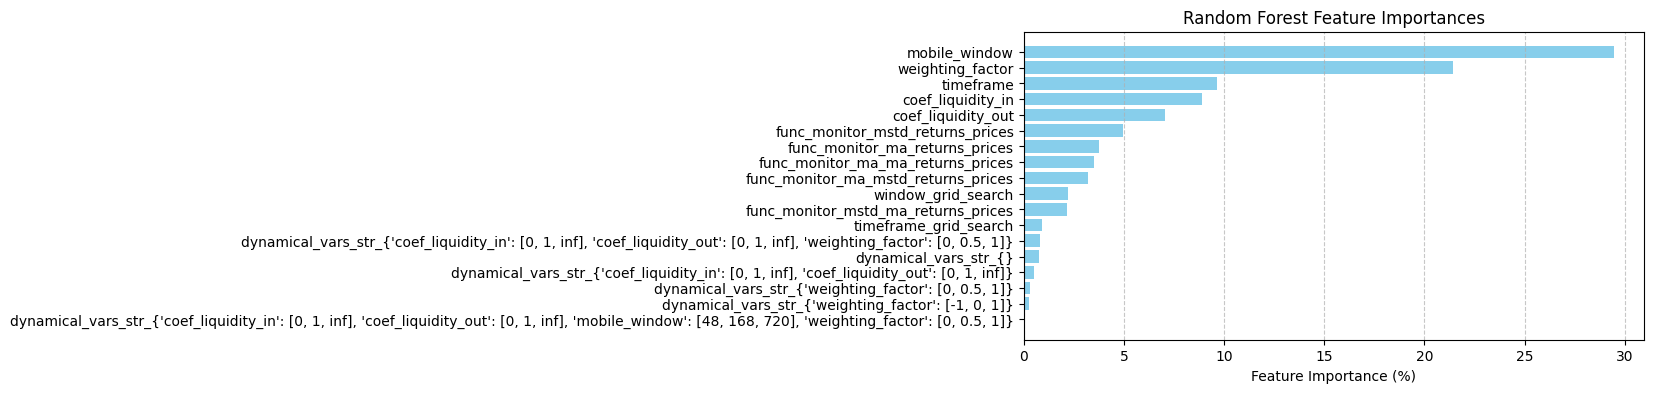

In [ ]:
# (dopo aver generato total_results, ad esempio)
model, df_prep = run_training_with_dynamical_vars(total_results)

# df_prep avrà le colonne one-hot (fra cui dynamical_vars_str_...), e potrai vedere
# la feature importance anche su "dynamical_vars_str_{...}"

In [ ]:
total_results['dynamical_variables'].value_counts()

dynamical_variables
{}                                                                                                                                         11698
{'coef_liquidity_in': [0, 1, inf], 'coef_liquidity_out': [0, 1, inf]}                                                                        110
{'weighting_factor': [0, 0.5, 1]}                                                                                                             96
{'coef_liquidity_in': [0, 1, inf], 'coef_liquidity_out': [0, 1, inf], 'weighting_factor': [0, 0.5, 1]}                                        48
{'weighting_factor': [-1, 0, 1]}                                                                                                              36
{'coef_liquidity_in': [0, 1, inf], 'coef_liquidity_out': [0, 1, inf], 'mobile_window': [48, 168, 720], 'weighting_factor': [0, 0.5, 1]}       24
Name: count, dtype: int64

## Reti neurali

In [ ]:
def train_neural_network_regressor(
    df: pd.DataFrame,
    feature_cols: list,
    target_col: str,
    train_pct: float = 0.6,
    val_pct: float = 0.2,
    random_state: int = 42,
    network_width: int = 64,
    network_depth: int = 3,
    activation_function: str = 'relu',
    patience: int = 10,
    epochs: int = 100,
    batch_size: int = 32,
    monitor: str = 'val_loss',
    loss: str = 'mse'
):
    """
    Allena una rete neurale per predire il valore continuo in `target_col` a partire dalle feature in `feature_cols`.
    I dati vengono suddivisi in train, validation e test in base ai parametri train_pct e val_pct.
    
    Parametri
    ----------
    df : pd.DataFrame
        DataFrame contenente le feature e il target.
    feature_cols : list
        Lista dei nomi delle colonne feature.
    target_col : str
        Nome della colonna target.
    train_pct : float, default 0.6
        Percentuale dei dati da usare per il training.
    val_pct : float, default 0.2
        Percentuale dei dati da usare per la validazione (il test set sarà 1 - train_pct - val_pct).
    random_state : int, default 42
        Seed per la riproducibilità.
    network_width : int, default 64
        Numero di neuroni in ogni strato hidden.
    network_depth : int, default 3
        Numero di strati hidden.
    activation_function : str, default 'relu'
        Funzione di attivazione da usare nei layer hidden.
    patience : int, default 10
        Numero di epoche da attendere prima di fermare l’allenamento in caso di mancato miglioramento (early stopping).
    epochs : int, default 100
        Numero massimo di epoche per l’allenamento.
    batch_size : int, default 32
        Dimensione del batch per l’allenamento.
    
    Ritorna
    --------
    model : tf.keras.Model
        Il modello neurale addestrato.
    history : tf.keras.callbacks.History
        L’oggetto history con le metriche di training.
    metrics_dict : dict
        Dizionario contenente MAE e MAPE (oltre a eventuali altre metriche) su train, validation e test.
    """
    # Estrai feature e target
    X = df[feature_cols].values
    y = df[target_col].values

    # Calcola la dimensione dei dataset
    test_pct = 1.0 - train_pct - val_pct
    if test_pct <= 0:
        raise ValueError("La somma di train_pct e val_pct deve essere minore di 1.0.")

    # Suddividi in train+val e test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_pct, random_state=random_state
    )
    # Ora, dividi X_train_val in train e validation
    relative_val_pct = val_pct / (train_pct + val_pct)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=relative_val_pct, random_state=random_state
    )

    # Costruisci il modello neurale
    model = Sequential()
    model.add(InputLayer(input_shape=(X.shape[1],)))
    for _ in range(network_depth):
        model.add(Dense(network_width, activation=activation_function))
    # Layer di output: 1 neurone, attivazione lineare
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer='adam', loss=loss, metrics=['mae', 'mape'])

    # Configura l'early stopping
    early_stop = EarlyStopping(monitor=monitor, patience=patience, restore_best_weights=True)

    # Allena il modello
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )

    # Valutazione sui tre set
    train_loss, train_mae, train_mape = model.evaluate(X_train, y_train, verbose=0)
    val_loss, val_mae, val_mape = model.evaluate(X_val, y_val, verbose=0)
    test_loss, test_mae, test_mape = model.evaluate(X_test, y_test, verbose=0)

    metrics_dict = {
        'train_loss': train_loss,
        'train_mae': train_mae,
        'train_mape': train_mape,
        'val_loss': val_loss,
        'val_mae': val_mae,
        'val_mape': val_mape,
        'test_loss': test_loss,
        'test_mae': test_mae,
        'test_mape': test_mape
    }

    # Plot dei grafici di training
    epochs_range = range(1, len(history.history['loss']) + 1)
    plt.figure(figsize=(18, 5))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, history.history['loss'], label='Train Loss')
    plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Loss durante l’Addestramento')
    plt.legend()
    plt.grid(True)

    # MAE
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, history.history['mae'], label='Train MAE')
    plt.plot(epochs_range, history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('MAE durante l’Addestramento')
    plt.legend()
    plt.grid(True)

    # MAPE
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, history.history['mape'], label='Train MAPE')
    plt.plot(epochs_range, history.history['val_mape'], label='Validation MAPE')
    plt.xlabel('Epoch')
    plt.ylabel('MAPE')
    plt.title('MAPE durante l’Addestramento')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print("Metriche finali:")
    print(metrics_dict)

    return model, history, metrics_dict

In [ ]:
def normalize_dynamical_vars_dict(d: dict) -> str:
    """
    Dato un dizionario `d` (es: {'func_monitor': [<function ma_returns_prices>, <function mstd_prices>],
                                'coef_liquidity_in': [0, inf]},
    costruisce una stringa canonica, in cui:
      - le chiavi sono in ordine alfabetico;
      - ogni valore (che e' *sempre* una lista) viene ordinato come stringhe;
      - i Callable vengono sostituiti col loro nome (.__name__),
      - i float speciali (inf) vengono convertiti in "inf",
      - e si genera uno spacing coerente.

    Esempio:
      {'func_monitor': [mstd_prices, ma_returns_prices], 'coef_liquidity_in': [1, inf]}
      => "{'coef_liquidity_in': [1, inf], 'func_monitor': [ma_returns_prices, mstd_prices]}"

    NOTA: se la chiave e' vuota o la lista e' vuota, la salviamo comunque, p.es. "'chiave': []"
    """

    # 1) Copia "logica" del dict (per non modificare l'originale).
    d_copy = dict(d)

    # 2) Creiamo una mappa (key -> string list) da cui costruire poi la stringa
    str_map = {}
    for k_raw, v_raw in d_copy.items():
        # Convertiamo la chiave in str (in genere e' gia' str)
        k = str(k_raw)

        # v_raw e' *sempre* una lista (da ipotesi).
        if not isinstance(v_raw, list):
            # Se per qualche ragione non e' una list, lo trasformiamo in lista con un solo elem
            v_list = [v_raw]
        else:
            v_list = v_raw

        # Ora convertiamo i suoi elementi in string in modo coerente
        converted_elems = []
        for elem in v_list:
            if callable(elem):
                # Funzione => usiamo elem.__name__
                converted_elems.append(elem.__name__)
            elif isinstance(elem, (int, float)):
                if str(elem) == 'inf':
                    converted_elems.append('inf')
                elif str(elem) == '-inf':
                    converted_elems.append('-inf')
                else:
                    converted_elems.append(str(elem))
            else:
                # Altri tipi (str, None, ecc.)
                converted_elems.append(str(elem))

        # Ordiniamo la lista di stringhe
        converted_elems.sort()
        str_map[k] = converted_elems

    # 3) Ordiniamo le chiavi e costruiamo la stringa finale
    sorted_keys = sorted(str_map.keys())
    parts = []
    for k in sorted_keys:
        # costruiamo p.es. "'coef_liquidity_in': [1,inf]"
        lista = str_map[k]
        # costruiamo "val1,val2,val3" senza spazi
        joined_vals = ",".join(lista)
        part = f"'{k}': [{joined_vals}]"
        parts.append(part)

    joined = ", ".join(parts)
    final_str = f"{{{joined}}}"
    return final_str


def flatten_dynamical_variables(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
    """
    Trasforma la colonna 'col_name' (che contiene sempre un dict,
    i cui valori sono SEMPRE liste di possibili tipi eterogenei)
    in una singola colonna 'dynamical_vars_str' di tipo string,
    uniformata con normalize_dynamical_vars_dict().

    Se per qualche riga 'col_name' non e' un dict, lo convertiamo in str() generica.
    """

    new_col_name = "dynamical_vars_str"
    new_col_values = []

    for val in df[col_name]:
        if isinstance(val, dict):
            # Normalizziamo il dict
            s = normalize_dynamical_vars_dict(val)
            new_col_values.append(s)
        else:
            # Non e' un dict (puo' essere None, o un residuo)
            new_col_values.append(str(val))

    df_out = df.copy()
    df_out[new_col_name] = new_col_values
    df_out.drop(columns=[col_name], inplace=True)
    return df_out

def run_training_with_dynamical_vars(risultati_df_ordinati):
    """
    Esempio di pipeline che:
      1) Converte la colonna 'dynamical_variables' in 'dynamical_vars_str'
         con normalizzazione.
      2) (Opzionale) Trasforma 'func_monitor' in stringa se esiste.
      3) Identifica tutte le colonne object (comprese dynamical_vars_str e func_monitor)
         e le One-Hot-encoda.
      4) Esegue la train_random_forest_regressor (R^2 e feature importance).
    """
    # Sostituisco anche np.inf, che potrebbe comparire nel dataframe, con un numero molto elevato
    risultati_df_ordinati.replace([np.inf], 999999999, inplace=True)

    # 1) Flatten la colonna "dynamical_variables" => 'dynamical_vars_str'
    df_flat = flatten_dynamical_variables(risultati_df_ordinati, 'dynamical_variables')

    # 2) Se c'e' la colonna 'func_monitor', la convertiamo in string (nome funzione)
    if 'func_monitor' in df_flat.columns:
        df_flat['func_monitor'] = df_flat['func_monitor'].apply(
            lambda x: x.__name__ if callable(x) else str(x)
        )

    # 3) Trova colonne di tipo object su cui fare one-hot
    cat_cols = []
    for c in df_flat.columns:
        if df_flat[c].dtype == object:
            cat_cols.append(c)

    # Escludi eventuali target object
    target_cols = ['fattore_rendimento_totale', 'volatility',
                   'calmar_ratio', 'sortino_ratio', 'sharpe_ratio', 'max_drawdown']
    cat_cols = [c for c in cat_cols if c not in target_cols]

    # 4) One-hot encoding
    oh = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    arr_encoded = oh.fit_transform(df_flat[cat_cols].astype(str))
    oh_cols = oh.get_feature_names_out(cat_cols)

    df_enc = pd.DataFrame(arr_encoded, columns=oh_cols, index=df_flat.index)

    # Concateniamo
    df_prep = pd.concat([df_flat.drop(columns=cat_cols), df_enc], axis=1)

    # 5) Selezioniamo le feature e il target
    target = 'fattore_rendimento_totale'
    exclude = ['fattore_rendimento_totale', 'volatility', 'calmar_ratio',
               'sortino_ratio', 'sharpe_ratio', 'max_drawdown']
    feature_cols = [c for c in df_prep.columns if c not in exclude]

    # Fisso varie cose per garantire la riproducibilità dei risultati

    SEED = 42
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    tf.config.experimental.enable_op_determinism()
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['OMP_NUM_THREADS'] = '1'
    os.environ['TF_NUM_INTRAOP_THREADS'] = '1'
    os.environ['TF_NUM_INTEROP_THREADS'] = '1'

    # 6) Allena la Random Forest
    model = train_neural_network_regressor(
        df=df_prep,
        feature_cols=feature_cols,
        target_col=target,
        train_pct = 0.6,
        val_pct = 0.2,
        random_state = SEED,
        network_width = 1024,
        network_depth = 3,
        activation_function = 'sigmoid',
        patience = 20,
        epochs = 10000,
        batch_size = 256,
        monitor = 'val_mape',
        loss = 'mape'
    )

    return model, df_prep

### Risultati reti neurali

c:\Users\Alessandro\Desktop\Cartelle\Mie\Programmi personali in Python\Giochi e simulazioni\Simulazioni\Simulatore di compravendita\Analisi Bitcoin\myenv\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10000
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - loss: 70.8403 - mae: 20.9025 - mape: 70.8403 - val_loss: 68.6399 - val_mae: 22.6763 - val_mape: 68.6399
Epoch 2/10000
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 65.1027 - mae: 20.7519 - mape: 65.1027 - val_loss: 68.1415 - val_mae: 22.6323 - val_mape: 68.1415
Epoch 3/10000
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 65.2266 - mae: 20.7561 - mape: 65.2266 - val_loss: 66.0131 - val_mae: 22.3461 - val_mape: 66.0131
Epoch 4/10000
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - loss: 64.4222 - mae: 20.6978 - mape: 64.4222 - val_loss: 65.5557 - val_mae: 22.2648 - val_mape: 65.5557
Epoch 5/10000
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 64.2433 - mae: 20.6832 - mape: 64.2433 - val_loss: 65.3901 - val_mae: 22.2166 - val_mape: 65.3901
Epoch 6/10000
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 64.1512 - mae: 20.6795 - mape: 64.1512 - val_loss: 65.7814 - val_mae: 22.2815 - val_mape: 65.7814
Epoch 7/10000
113/113 ━━

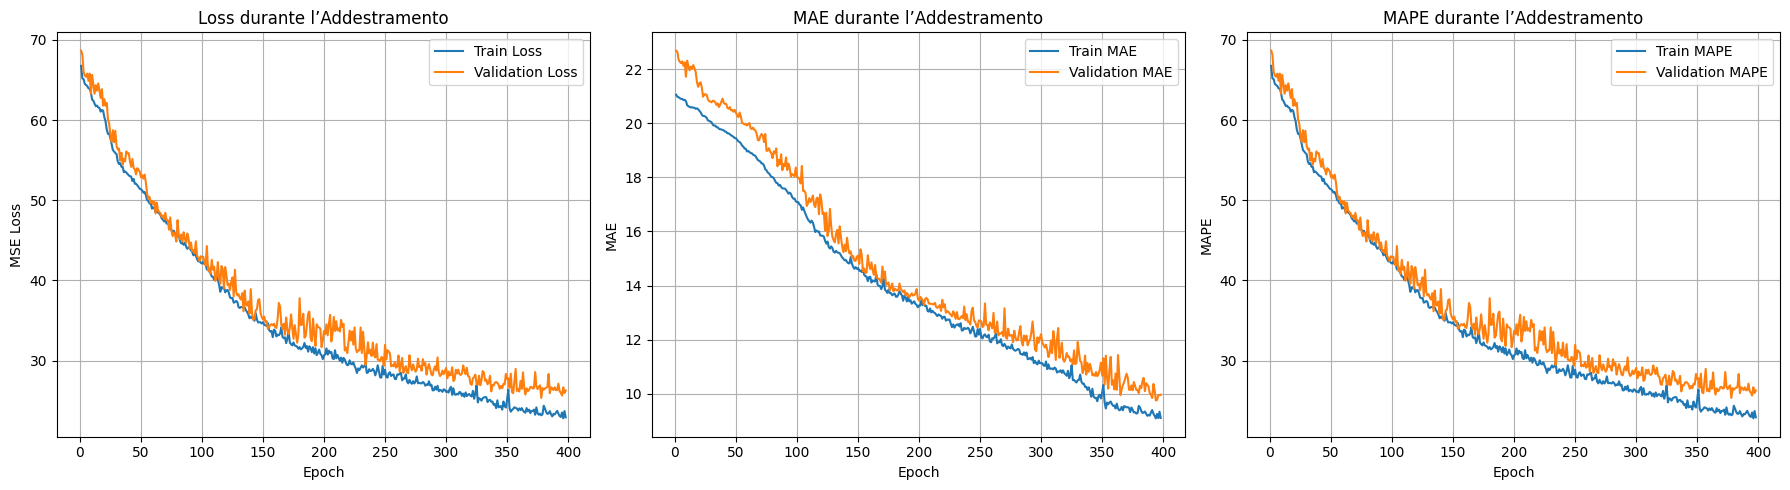

Metriche finali:
{'train_loss': 22.446447372436523, 'train_mae': 9.24516487121582, 'train_mape': 22.446447372436523, 'val_loss': 25.35419273376465, 'val_mae': 10.149881362915039, 'val_mape': 25.35419273376465, 'test_loss': 24.199647903442383, 'test_mae': 9.905316352844238, 'test_mape': 24.199647903442383}
df_prep:


,coef_liquidity_in,coef_liquidity_out,mobile_window,timeframe,timeframe_grid_search,weighting_factor,window_grid_search,fattore_rendimento_totale,volatility,max_drawdown,sharpe_ratio,sortino_ratio,calmar_ratio,func_monitor_ma_ma_returns_prices,func_monitor_ma_mstd_returns_prices,func_monitor_ma_returns_prices,func_monitor_mstd_ma_returns_prices,func_monitor_mstd_returns_prices,"dynamical_vars_str_{'coef_liquidity_in': [0, 1, inf], 'coef_liquidity_out': [0, 1, inf], 'mobile_window': [48, 168, 720], 'weighting_factor': [0, 0.5, 1]}","dynamical_vars_str_{'coef_liquidity_in': [0, 1, inf], 'coef_liquidity_out': [0, 1, inf], 'weighting_factor': [0, 0.5, 1]}","dynamical_vars_str_{'coef_liquidity_in': [0, 1, inf], 'coef_liquidity_out': [0, 1, inf]}","dynamical_vars_str_{'weighting_factor': [-1, 0, 1]}","dynamical_vars_str_{'weighting_factor': [0, 0.5, 1]}",dynamical_vars_str_{}
0,0.5,0.5,12,336,-1,0.5,168,584.680223,0.312325,64.151079,0.738917,1.344669,909.852541,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.5,1.5,12,336,-1,0.5,168,561.990908,0.311224,64.151079,0.736776,1.340011,874.483978,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,48,336,-1,0.0,720,553.135050,0.351338,68.194708,0.688079,1.250061,809.645007,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,48,336,-1,0.0,360,551.411699,0.348896,68.194708,0.690294,1.253264,807.117903,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,999999999.0,168,336,-1,1.0,360,543.160563,0.416453,70.248045,0.631897,1.230622,771.780286,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12007,999999999.0,999999999.0,336,168,-1,-1.0,168,0.590056,0.150105,79.583430,-0.026005,-0.037898,-0.515112,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12008,999999999.0,3.0,336,168,-1,-1.0,168,0.546440,0.150850,81.092590,-0.039835,-0.058133,-0.559311,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12009,999999999.0,3.0,336,336,-1,-1.0,168,0.406972,0.154141,85.787925,-0.090936,-0.132922,-0.691272,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12010,999999999.0,10.0,336,336,-1,-1.0,168,0.398157,0.154045,86.095755,-0.095195,-0.138968,-0.699039,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
model, df_prep = run_training_with_dynamical_vars(total_results)
print('df_prep:')
df_prep